# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

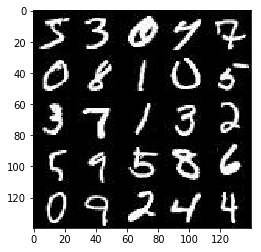

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

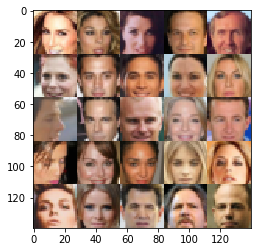

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    print('image_width, image_height, image_channels',image_width, image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    print('z_dim',z_dim)
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, [], name = 'input_lr')

    return input_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

image_width, image_height, image_channels 28 28 3
z_dim 100
Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Constant for the leaky relu.
alpha = 0.2

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3    28x28xOUT
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha*x1, x1)
        # 16x16x64  14x14xOUT
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 8x8x128   7x7xOUT
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 1, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 7*7*128) )
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolution stack
        x1 = tf.reshape(x, (-1, 7, 7, 256) )
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 4x4x512 now      7x7xOUT
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 8x8x256 now     14x14xOUT   
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides = 1, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 16x16x128     28x28xOUT
     
        # Output layer, 32x32x3  28x28xOUT
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding = 'same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # tf.reset_default_graph()
    print('*data_shape[1:4]',*data_shape[1:4])
    print('z_dim',z_dim)
    input_real, input_z, input_lr = model_inputs(*data_shape[1:4], z_dim)
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
 
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_lr, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
        
            print('epoch_i', epoch_i)
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)

                    show_generator_output(sess, 5, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

*data_shape[1:4] 28 28 1
z_dim 10
image_width, image_height, image_channels 28 28 1
z_dim 10
epoch_i 0
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 4.0248
Epoch 1/2... Discriminator Loss: 1.8490... Generator Loss: 0.4346
Epoch 1/2... Discriminator Loss: 1.8825... Generator Loss: 4.2655
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 2.4141
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.7839
Epoch 1/2... Discriminator Loss: 2.4505... Generator Loss: 5.7341
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 1.5870


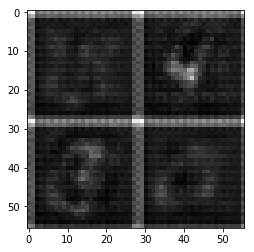

Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 0.5098... Generator Loss: 1.2539
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 5.3199
Epoch 1/2... Discriminator Loss: 0.6293... Generator Loss: 2.7440
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 1.0276
Epoch 1/2... Discriminator Loss: 0.6089... Generator Loss: 1.5577
Epoch 1/2... Discriminator Loss: 0.6537... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 0.3125... Generator Loss: 2.0077
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 1.7428
Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 0.8789


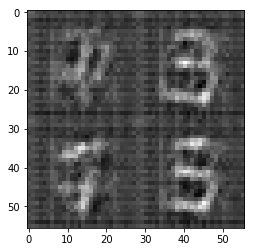

Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 3.2439
Epoch 1/2... Discriminator Loss: 0.3133... Generator Loss: 2.3164
Epoch 1/2... Discriminator Loss: 0.4237... Generator Loss: 1.4989
Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 0.6696... Generator Loss: 0.9881
Epoch 1/2... Discriminator Loss: 0.2473... Generator Loss: 2.2701
Epoch 1/2... Discriminator Loss: 0.2372... Generator Loss: 2.6644
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 0.3664... Generator Loss: 1.6335


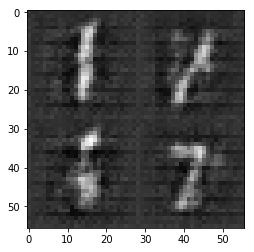

Epoch 1/2... Discriminator Loss: 0.3520... Generator Loss: 1.7665
Epoch 1/2... Discriminator Loss: 0.3427... Generator Loss: 1.7280
Epoch 1/2... Discriminator Loss: 0.1805... Generator Loss: 2.5033
Epoch 1/2... Discriminator Loss: 0.6027... Generator Loss: 1.2935
Epoch 1/2... Discriminator Loss: 0.3198... Generator Loss: 3.2468
Epoch 1/2... Discriminator Loss: 0.1837... Generator Loss: 2.8242
Epoch 1/2... Discriminator Loss: 0.2053... Generator Loss: 2.2956
Epoch 1/2... Discriminator Loss: 0.1342... Generator Loss: 3.0714
Epoch 1/2... Discriminator Loss: 0.1766... Generator Loss: 2.1881
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 0.6241


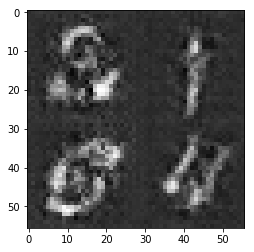

Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 1.6793
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 3.4818
Epoch 1/2... Discriminator Loss: 0.3305... Generator Loss: 2.3832
Epoch 1/2... Discriminator Loss: 0.2610... Generator Loss: 2.0686
Epoch 1/2... Discriminator Loss: 0.1896... Generator Loss: 2.2763
Epoch 1/2... Discriminator Loss: 0.1830... Generator Loss: 2.7274
Epoch 1/2... Discriminator Loss: 0.2050... Generator Loss: 2.2361
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.0856
Epoch 1/2... Discriminator Loss: 0.2930... Generator Loss: 1.9925
Epoch 1/2... Discriminator Loss: 0.2672... Generator Loss: 1.8693


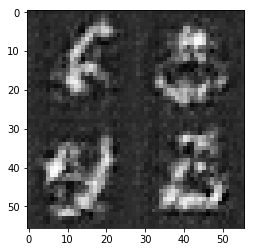

Epoch 1/2... Discriminator Loss: 0.1973... Generator Loss: 2.5955
Epoch 1/2... Discriminator Loss: 0.2733... Generator Loss: 1.8021
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 1.4844
Epoch 1/2... Discriminator Loss: 0.1385... Generator Loss: 2.6609
Epoch 1/2... Discriminator Loss: 0.1806... Generator Loss: 4.6576
Epoch 1/2... Discriminator Loss: 0.0490... Generator Loss: 3.8218
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 1.2320
Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 2.0754
Epoch 1/2... Discriminator Loss: 0.2996... Generator Loss: 2.1380
Epoch 1/2... Discriminator Loss: 0.1591... Generator Loss: 2.7374


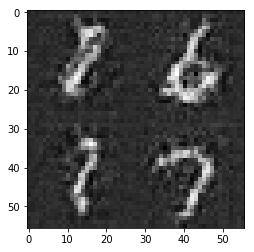

Epoch 1/2... Discriminator Loss: 0.4643... Generator Loss: 1.6828
Epoch 1/2... Discriminator Loss: 0.2055... Generator Loss: 2.1637
Epoch 1/2... Discriminator Loss: 0.1909... Generator Loss: 2.3089
Epoch 1/2... Discriminator Loss: 0.2311... Generator Loss: 2.0850
Epoch 1/2... Discriminator Loss: 0.2334... Generator Loss: 1.8906
Epoch 1/2... Discriminator Loss: 0.1169... Generator Loss: 3.0642
Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 2.9180
Epoch 1/2... Discriminator Loss: 0.8025... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 0.3810... Generator Loss: 2.0122
Epoch 1/2... Discriminator Loss: 0.2960... Generator Loss: 1.7682


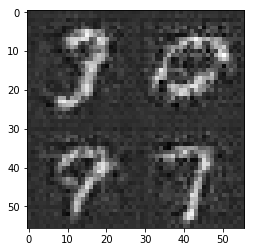

Epoch 1/2... Discriminator Loss: 0.3181... Generator Loss: 1.9993
Epoch 1/2... Discriminator Loss: 0.4033... Generator Loss: 1.5791
Epoch 1/2... Discriminator Loss: 0.3047... Generator Loss: 2.3092
Epoch 1/2... Discriminator Loss: 0.1553... Generator Loss: 2.4915
Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 1.7953
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 1.3006
Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 1.4014
Epoch 1/2... Discriminator Loss: 0.4968... Generator Loss: 1.5354
Epoch 1/2... Discriminator Loss: 0.2178... Generator Loss: 2.2813
Epoch 1/2... Discriminator Loss: 0.2273... Generator Loss: 2.0206


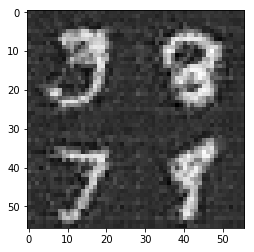

Epoch 1/2... Discriminator Loss: 0.2093... Generator Loss: 2.0800
Epoch 1/2... Discriminator Loss: 0.1030... Generator Loss: 3.6615
Epoch 1/2... Discriminator Loss: 0.1035... Generator Loss: 3.2164
Epoch 1/2... Discriminator Loss: 0.0564... Generator Loss: 3.4988
Epoch 1/2... Discriminator Loss: 0.0935... Generator Loss: 3.8900
Epoch 1/2... Discriminator Loss: 0.0692... Generator Loss: 3.5907
Epoch 1/2... Discriminator Loss: 0.1499... Generator Loss: 2.5064
Epoch 1/2... Discriminator Loss: 0.5867... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 3.3238... Generator Loss: 5.1895
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 3.0208


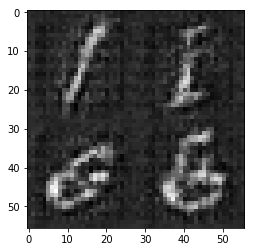

Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 0.2367... Generator Loss: 2.2764
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 1.4762
epoch_i 1
Epoch 2/2... Discriminator Loss: 0.1493... Generator Loss: 2.5476
Epoch 2/2... Discriminator Loss: 0.2406... Generator Loss: 1.8201
Epoch 2/2... Discriminator Loss: 0.0600... Generator Loss: 4.5036
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 3.5501
Epoch 2/2... Discriminator Loss: 0.4617... Generator Loss: 1.4250
Epoch 2/2... Discriminator Loss: 0.3884... Generator Loss: 1.6861
Epoch 2/2... Discriminator Loss: 0.2538... Generator Loss: 1.9821


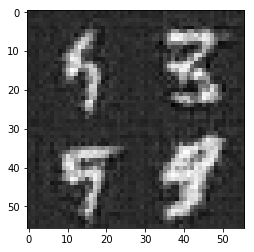

Epoch 2/2... Discriminator Loss: 0.1557... Generator Loss: 2.3983
Epoch 2/2... Discriminator Loss: 0.0584... Generator Loss: 4.2804
Epoch 2/2... Discriminator Loss: 0.0824... Generator Loss: 4.0034
Epoch 2/2... Discriminator Loss: 0.1410... Generator Loss: 2.4342
Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 2.6371
Epoch 2/2... Discriminator Loss: 0.3863... Generator Loss: 1.7553
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 4.1576
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 2.9786
Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 1.5830
Epoch 2/2... Discriminator Loss: 0.4934... Generator Loss: 1.6313


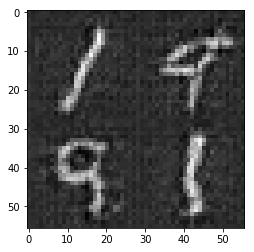

Epoch 2/2... Discriminator Loss: 0.2211... Generator Loss: 2.3996
Epoch 2/2... Discriminator Loss: 0.1577... Generator Loss: 2.7730
Epoch 2/2... Discriminator Loss: 0.0917... Generator Loss: 3.3643
Epoch 2/2... Discriminator Loss: 0.2272... Generator Loss: 1.9855
Epoch 2/2... Discriminator Loss: 0.1319... Generator Loss: 2.5503
Epoch 2/2... Discriminator Loss: 0.1196... Generator Loss: 2.6502
Epoch 2/2... Discriminator Loss: 0.0498... Generator Loss: 3.9801
Epoch 2/2... Discriminator Loss: 0.2252... Generator Loss: 1.9807
Epoch 2/2... Discriminator Loss: 0.5644... Generator Loss: 2.0012
Epoch 2/2... Discriminator Loss: 0.5384... Generator Loss: 1.4079


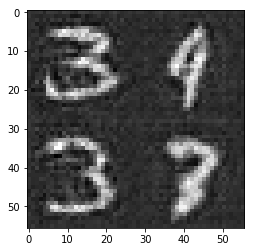

Epoch 2/2... Discriminator Loss: 0.3632... Generator Loss: 2.3908
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 1.3986
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 0.5836... Generator Loss: 2.0468
Epoch 2/2... Discriminator Loss: 0.4123... Generator Loss: 1.8639
Epoch 2/2... Discriminator Loss: 0.2589... Generator Loss: 2.2011
Epoch 2/2... Discriminator Loss: 0.0916... Generator Loss: 3.6842
Epoch 2/2... Discriminator Loss: 0.0610... Generator Loss: 3.9760
Epoch 2/2... Discriminator Loss: 0.1185... Generator Loss: 2.6428


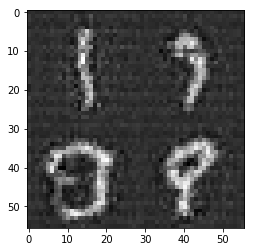

Epoch 2/2... Discriminator Loss: 0.1118... Generator Loss: 2.6699
Epoch 2/2... Discriminator Loss: 0.0776... Generator Loss: 3.3963
Epoch 2/2... Discriminator Loss: 0.0295... Generator Loss: 5.1850
Epoch 2/2... Discriminator Loss: 0.0575... Generator Loss: 4.6439
Epoch 2/2... Discriminator Loss: 0.0723... Generator Loss: 4.9506
Epoch 2/2... Discriminator Loss: 0.0346... Generator Loss: 3.9853
Epoch 2/2... Discriminator Loss: 0.0712... Generator Loss: 3.9397
Epoch 2/2... Discriminator Loss: 0.0759... Generator Loss: 3.5561
Epoch 2/2... Discriminator Loss: 0.0505... Generator Loss: 3.7173
Epoch 2/2... Discriminator Loss: 1.6901... Generator Loss: 0.3409


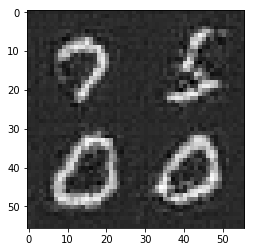

Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 1.2618
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 2.0218
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 1.8884
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 1.2736
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.1836
Epoch 2/2... Discriminator Loss: 0.4615... Generator Loss: 1.9093
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 2.3832
Epoch 2/2... Discriminator Loss: 0.3154... Generator Loss: 2.1267
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 1.3893


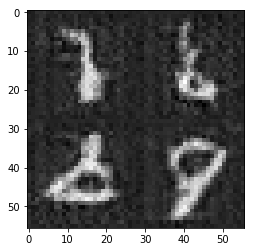

Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 0.3178... Generator Loss: 2.7733
Epoch 2/2... Discriminator Loss: 0.3225... Generator Loss: 2.3499
Epoch 2/2... Discriminator Loss: 0.3107... Generator Loss: 2.1266
Epoch 2/2... Discriminator Loss: 0.2870... Generator Loss: 1.8893
Epoch 2/2... Discriminator Loss: 0.2944... Generator Loss: 1.7316
Epoch 2/2... Discriminator Loss: 0.2898... Generator Loss: 1.7832
Epoch 2/2... Discriminator Loss: 3.5817... Generator Loss: 8.9538
Epoch 2/2... Discriminator Loss: 0.7109... Generator Loss: 1.2774
Epoch 2/2... Discriminator Loss: 0.4671... Generator Loss: 2.6545


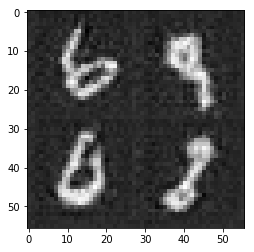

Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 0.5923... Generator Loss: 2.3321
Epoch 2/2... Discriminator Loss: 0.4357... Generator Loss: 1.7621
Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 1.2593
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 1.4368
Epoch 2/2... Discriminator Loss: 0.1524... Generator Loss: 2.6260
Epoch 2/2... Discriminator Loss: 0.1520... Generator Loss: 2.9909
Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 2.4014
Epoch 2/2... Discriminator Loss: 0.3620... Generator Loss: 1.8709
Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 2.6311


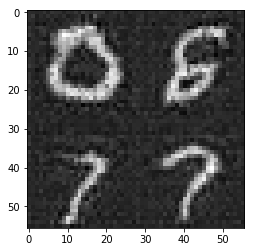

Epoch 2/2... Discriminator Loss: 0.2833... Generator Loss: 1.8994
Epoch 2/2... Discriminator Loss: 0.1930... Generator Loss: 2.2666
Epoch 2/2... Discriminator Loss: 0.1907... Generator Loss: 2.2399
Epoch 2/2... Discriminator Loss: 0.1694... Generator Loss: 2.3357
Epoch 2/2... Discriminator Loss: 0.1351... Generator Loss: 2.5097
Epoch 2/2... Discriminator Loss: 0.0438... Generator Loss: 4.1126
Epoch 2/2... Discriminator Loss: 0.0563... Generator Loss: 3.8889
Epoch 2/2... Discriminator Loss: 0.0449... Generator Loss: 4.5658
Epoch 2/2... Discriminator Loss: 0.0206... Generator Loss: 5.0457
Epoch 2/2... Discriminator Loss: 0.4000... Generator Loss: 1.4109


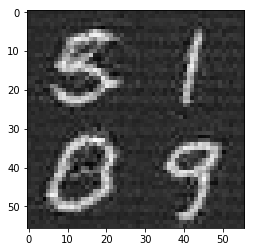

Epoch 2/2... Discriminator Loss: 0.0240... Generator Loss: 5.5784
Epoch 2/2... Discriminator Loss: 0.0891... Generator Loss: 3.1254
Epoch 2/2... Discriminator Loss: 3.9561... Generator Loss: 0.1866
Epoch 2/2... Discriminator Loss: 0.6117... Generator Loss: 2.7473
Epoch 2/2... Discriminator Loss: 0.3844... Generator Loss: 1.5888
Epoch 2/2... Discriminator Loss: 1.8582... Generator Loss: 0.2838
Epoch 2/2... Discriminator Loss: 0.3744... Generator Loss: 1.7218


In [12]:
batch_size = 64
z_dim = 10
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

*data_shape[1:4] 28 28 3
z_dim 100
image_width, image_height, image_channels 28 28 3
z_dim 100
epoch_i 0
Epoch 1/30... Discriminator Loss: 1.5276... Generator Loss: 0.4620
Epoch 1/30... Discriminator Loss: 1.5288... Generator Loss: 8.9743
Epoch 1/30... Discriminator Loss: 4.2702... Generator Loss: 0.1000
Epoch 1/30... Discriminator Loss: 1.0631... Generator Loss: 3.7091
Epoch 1/30... Discriminator Loss: 0.6283... Generator Loss: 1.2766
Epoch 1/30... Discriminator Loss: 0.4726... Generator Loss: 1.3799
Epoch 1/30... Discriminator Loss: 2.2494... Generator Loss: 9.2643
Epoch 1/30... Discriminator Loss: 0.7135... Generator Loss: 0.8969
Epoch 1/30... Discriminator Loss: 1.6169... Generator Loss: 0.3320
Epoch 1/30... Discriminator Loss: 0.2103... Generator Loss: 6.6340


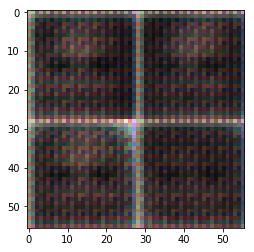

Epoch 1/30... Discriminator Loss: 1.1085... Generator Loss: 0.6739
Epoch 1/30... Discriminator Loss: 0.1331... Generator Loss: 5.3812
Epoch 1/30... Discriminator Loss: 1.4641... Generator Loss: 0.7131
Epoch 1/30... Discriminator Loss: 1.2296... Generator Loss: 0.5114
Epoch 1/30... Discriminator Loss: 0.8779... Generator Loss: 6.1190
Epoch 1/30... Discriminator Loss: 1.1952... Generator Loss: 5.4730
Epoch 1/30... Discriminator Loss: 0.2601... Generator Loss: 3.6152
Epoch 1/30... Discriminator Loss: 0.4111... Generator Loss: 5.6665
Epoch 1/30... Discriminator Loss: 0.0898... Generator Loss: 4.7149
Epoch 1/30... Discriminator Loss: 2.1897... Generator Loss: 0.1857


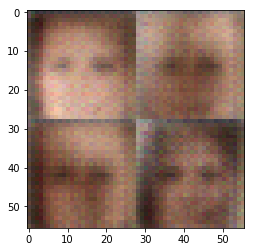

Epoch 1/30... Discriminator Loss: 1.1451... Generator Loss: 2.3829
Epoch 1/30... Discriminator Loss: 0.2454... Generator Loss: 1.9137
Epoch 1/30... Discriminator Loss: 0.1987... Generator Loss: 2.1415
Epoch 1/30... Discriminator Loss: 0.0915... Generator Loss: 3.3505
Epoch 1/30... Discriminator Loss: 0.5012... Generator Loss: 1.4181
Epoch 1/30... Discriminator Loss: 0.6799... Generator Loss: 0.8894
Epoch 1/30... Discriminator Loss: 0.0554... Generator Loss: 3.9590
Epoch 1/30... Discriminator Loss: 0.1015... Generator Loss: 4.0142
Epoch 1/30... Discriminator Loss: 0.6586... Generator Loss: 5.9121
Epoch 1/30... Discriminator Loss: 0.1127... Generator Loss: 7.3794


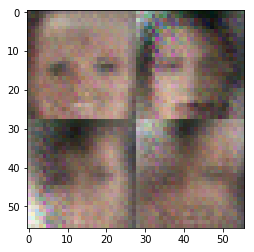

Epoch 1/30... Discriminator Loss: 0.0805... Generator Loss: 4.0444
Epoch 1/30... Discriminator Loss: 0.0260... Generator Loss: 5.1137
Epoch 1/30... Discriminator Loss: 0.5175... Generator Loss: 1.2307
Epoch 1/30... Discriminator Loss: 2.1050... Generator Loss: 0.1877
Epoch 1/30... Discriminator Loss: 0.1054... Generator Loss: 6.8468
Epoch 1/30... Discriminator Loss: 0.0664... Generator Loss: 3.6267
Epoch 1/30... Discriminator Loss: 0.2983... Generator Loss: 1.6236
Epoch 1/30... Discriminator Loss: 0.0188... Generator Loss: 4.6270
Epoch 1/30... Discriminator Loss: 0.0143... Generator Loss: 7.4973
Epoch 1/30... Discriminator Loss: 0.0358... Generator Loss: 4.9120


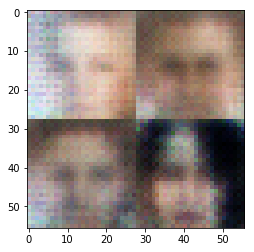

Epoch 1/30... Discriminator Loss: 0.0064... Generator Loss: 7.0227
Epoch 1/30... Discriminator Loss: 0.0276... Generator Loss: 8.8604
Epoch 1/30... Discriminator Loss: 2.4682... Generator Loss: 0.1331
Epoch 1/30... Discriminator Loss: 1.4523... Generator Loss: 0.3301
Epoch 1/30... Discriminator Loss: 0.0793... Generator Loss: 3.2968
Epoch 1/30... Discriminator Loss: 0.0654... Generator Loss: 3.7124
Epoch 1/30... Discriminator Loss: 0.6436... Generator Loss: 0.9620
Epoch 1/30... Discriminator Loss: 0.0491... Generator Loss: 4.8280
Epoch 1/30... Discriminator Loss: 0.0103... Generator Loss: 8.2420
Epoch 1/30... Discriminator Loss: 0.8530... Generator Loss: 12.2475


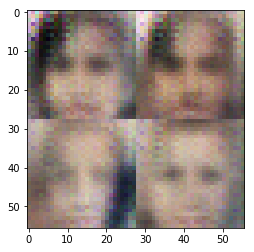

Epoch 1/30... Discriminator Loss: 1.0202... Generator Loss: 0.6189
Epoch 1/30... Discriminator Loss: 0.2146... Generator Loss: 2.1687
Epoch 1/30... Discriminator Loss: 0.0116... Generator Loss: 7.4989
Epoch 1/30... Discriminator Loss: 0.0282... Generator Loss: 6.0086
Epoch 1/30... Discriminator Loss: 0.0127... Generator Loss: 5.7014
Epoch 1/30... Discriminator Loss: 0.0257... Generator Loss: 4.4489
Epoch 1/30... Discriminator Loss: 0.0245... Generator Loss: 7.2496
Epoch 1/30... Discriminator Loss: 0.0229... Generator Loss: 7.6679
Epoch 1/30... Discriminator Loss: 0.0487... Generator Loss: 8.3917
Epoch 1/30... Discriminator Loss: 0.0045... Generator Loss: 7.4895


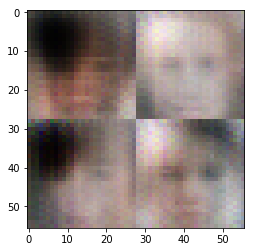

Epoch 1/30... Discriminator Loss: 0.0715... Generator Loss: 4.9841
Epoch 1/30... Discriminator Loss: 0.1298... Generator Loss: 2.6321
Epoch 1/30... Discriminator Loss: 1.1118... Generator Loss: 1.2691
Epoch 1/30... Discriminator Loss: 0.1649... Generator Loss: 2.7438
Epoch 1/30... Discriminator Loss: 0.0416... Generator Loss: 3.7473
Epoch 1/30... Discriminator Loss: 0.1922... Generator Loss: 2.2026
Epoch 1/30... Discriminator Loss: 0.0142... Generator Loss: 5.4433
Epoch 1/30... Discriminator Loss: 0.8480... Generator Loss: 1.9158
Epoch 1/30... Discriminator Loss: 0.1453... Generator Loss: 4.6856
Epoch 1/30... Discriminator Loss: 0.4364... Generator Loss: 1.4264


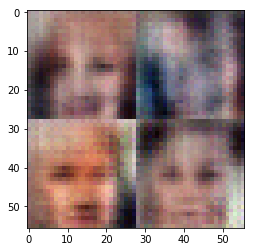

Epoch 1/30... Discriminator Loss: 1.3273... Generator Loss: 2.5938
Epoch 1/30... Discriminator Loss: 0.0518... Generator Loss: 3.8224
Epoch 1/30... Discriminator Loss: 0.0446... Generator Loss: 6.4667
Epoch 1/30... Discriminator Loss: 0.8684... Generator Loss: 0.7146
Epoch 1/30... Discriminator Loss: 0.1610... Generator Loss: 2.3059
Epoch 1/30... Discriminator Loss: 0.0227... Generator Loss: 7.0261
Epoch 1/30... Discriminator Loss: 0.9346... Generator Loss: 2.9676
Epoch 1/30... Discriminator Loss: 0.0367... Generator Loss: 7.2237
Epoch 1/30... Discriminator Loss: 1.0109... Generator Loss: 7.4931
Epoch 1/30... Discriminator Loss: 0.6340... Generator Loss: 0.9664


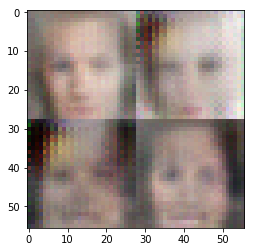

Epoch 1/30... Discriminator Loss: 0.1742... Generator Loss: 5.0612
Epoch 1/30... Discriminator Loss: 1.2531... Generator Loss: 0.7498
Epoch 1/30... Discriminator Loss: 2.5241... Generator Loss: 3.8352
Epoch 1/30... Discriminator Loss: 0.0818... Generator Loss: 3.5731
Epoch 1/30... Discriminator Loss: 0.3587... Generator Loss: 1.9131
Epoch 1/30... Discriminator Loss: 0.2389... Generator Loss: 2.5972
Epoch 1/30... Discriminator Loss: 1.4616... Generator Loss: 5.7050
Epoch 1/30... Discriminator Loss: 2.8233... Generator Loss: 0.1867
Epoch 1/30... Discriminator Loss: 3.4041... Generator Loss: 6.8410
Epoch 1/30... Discriminator Loss: 0.8130... Generator Loss: 0.8077


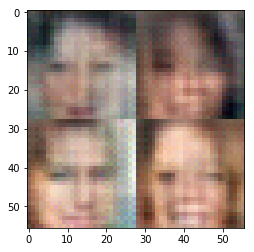

Epoch 1/30... Discriminator Loss: 0.4014... Generator Loss: 5.3817
Epoch 1/30... Discriminator Loss: 0.1761... Generator Loss: 3.0065
Epoch 1/30... Discriminator Loss: 0.0362... Generator Loss: 7.2336
Epoch 1/30... Discriminator Loss: 1.5446... Generator Loss: 0.4176
Epoch 1/30... Discriminator Loss: 3.4894... Generator Loss: 0.0543
Epoch 1/30... Discriminator Loss: 0.0528... Generator Loss: 4.5697
Epoch 1/30... Discriminator Loss: 0.1887... Generator Loss: 2.9273
Epoch 1/30... Discriminator Loss: 0.7997... Generator Loss: 0.8019
Epoch 1/30... Discriminator Loss: 1.6288... Generator Loss: 7.2305
Epoch 1/30... Discriminator Loss: 1.4386... Generator Loss: 0.3714


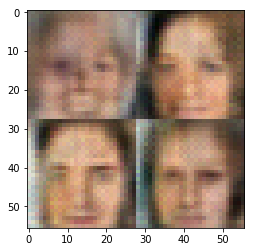

Epoch 1/30... Discriminator Loss: 0.2238... Generator Loss: 2.1349
Epoch 1/30... Discriminator Loss: 0.0181... Generator Loss: 5.1109
Epoch 1/30... Discriminator Loss: 0.1459... Generator Loss: 6.4773
Epoch 1/30... Discriminator Loss: 0.5314... Generator Loss: 3.9666
Epoch 1/30... Discriminator Loss: 1.5514... Generator Loss: 0.3504
Epoch 1/30... Discriminator Loss: 0.4251... Generator Loss: 1.4907
Epoch 1/30... Discriminator Loss: 0.1373... Generator Loss: 2.9642
Epoch 1/30... Discriminator Loss: 0.0842... Generator Loss: 6.4146
Epoch 1/30... Discriminator Loss: 2.1225... Generator Loss: 0.1761
Epoch 1/30... Discriminator Loss: 0.9738... Generator Loss: 3.5115


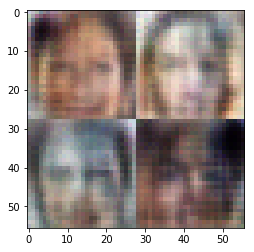

Epoch 1/30... Discriminator Loss: 0.8047... Generator Loss: 0.8190
Epoch 1/30... Discriminator Loss: 0.0089... Generator Loss: 6.3200
Epoch 1/30... Discriminator Loss: 0.0185... Generator Loss: 4.2699
Epoch 1/30... Discriminator Loss: 0.1717... Generator Loss: 3.6489
Epoch 1/30... Discriminator Loss: 0.0142... Generator Loss: 7.0421
Epoch 1/30... Discriminator Loss: 1.1505... Generator Loss: 0.5057
Epoch 1/30... Discriminator Loss: 0.4316... Generator Loss: 1.9571
Epoch 1/30... Discriminator Loss: 0.3690... Generator Loss: 3.5471
Epoch 1/30... Discriminator Loss: 1.1990... Generator Loss: 1.4819
Epoch 1/30... Discriminator Loss: 1.3156... Generator Loss: 3.5983


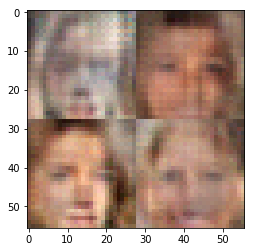

Epoch 1/30... Discriminator Loss: 0.1348... Generator Loss: 2.7917
Epoch 1/30... Discriminator Loss: 0.1432... Generator Loss: 6.3603
Epoch 1/30... Discriminator Loss: 0.0974... Generator Loss: 4.7256
Epoch 1/30... Discriminator Loss: 1.0703... Generator Loss: 2.7293
Epoch 1/30... Discriminator Loss: 1.2587... Generator Loss: 0.5052
Epoch 1/30... Discriminator Loss: 0.2522... Generator Loss: 3.6489
Epoch 1/30... Discriminator Loss: 0.5125... Generator Loss: 1.5743
Epoch 1/30... Discriminator Loss: 0.3199... Generator Loss: 1.6601
Epoch 1/30... Discriminator Loss: 1.7387... Generator Loss: 0.5881
Epoch 1/30... Discriminator Loss: 1.0460... Generator Loss: 0.8889


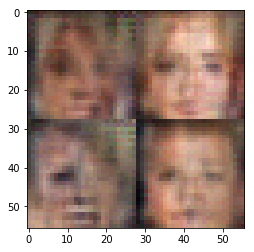

Epoch 1/30... Discriminator Loss: 0.8875... Generator Loss: 1.1198
Epoch 1/30... Discriminator Loss: 0.7167... Generator Loss: 1.0493
Epoch 1/30... Discriminator Loss: 1.1178... Generator Loss: 1.5412
Epoch 1/30... Discriminator Loss: 1.6399... Generator Loss: 5.0283
Epoch 1/30... Discriminator Loss: 0.7779... Generator Loss: 1.3563
Epoch 1/30... Discriminator Loss: 0.0425... Generator Loss: 4.6962
Epoch 1/30... Discriminator Loss: 1.1847... Generator Loss: 0.5127
Epoch 1/30... Discriminator Loss: 1.1560... Generator Loss: 0.7756
Epoch 1/30... Discriminator Loss: 0.0570... Generator Loss: 5.6283
Epoch 1/30... Discriminator Loss: 0.2318... Generator Loss: 3.6600


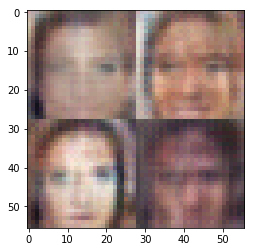

Epoch 1/30... Discriminator Loss: 0.2063... Generator Loss: 2.5839
Epoch 1/30... Discriminator Loss: 1.1501... Generator Loss: 0.5116
Epoch 1/30... Discriminator Loss: 0.4979... Generator Loss: 1.2531
Epoch 1/30... Discriminator Loss: 0.9083... Generator Loss: 0.7995
Epoch 1/30... Discriminator Loss: 0.2020... Generator Loss: 2.1231
Epoch 1/30... Discriminator Loss: 0.5847... Generator Loss: 2.8436
Epoch 1/30... Discriminator Loss: 0.9293... Generator Loss: 1.1708
Epoch 1/30... Discriminator Loss: 0.0698... Generator Loss: 4.7899
Epoch 1/30... Discriminator Loss: 0.0348... Generator Loss: 4.2262
Epoch 1/30... Discriminator Loss: 1.0971... Generator Loss: 0.9984


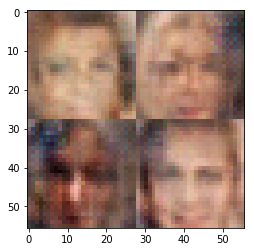

Epoch 1/30... Discriminator Loss: 0.2348... Generator Loss: 3.5512
Epoch 1/30... Discriminator Loss: 0.0396... Generator Loss: 6.5745
Epoch 1/30... Discriminator Loss: 0.0307... Generator Loss: 7.3039
Epoch 1/30... Discriminator Loss: 0.2191... Generator Loss: 2.4698
Epoch 1/30... Discriminator Loss: 1.9044... Generator Loss: 0.3681
Epoch 1/30... Discriminator Loss: 0.0754... Generator Loss: 3.9422
Epoch 1/30... Discriminator Loss: 0.9760... Generator Loss: 1.5230
Epoch 1/30... Discriminator Loss: 0.2098... Generator Loss: 3.0883
epoch_i 1
Epoch 2/30... Discriminator Loss: 1.7650... Generator Loss: 4.4739
Epoch 2/30... Discriminator Loss: 0.1826... Generator Loss: 4.8506


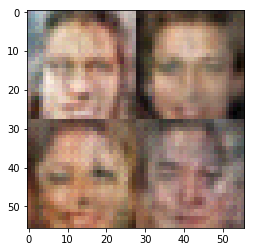

Epoch 2/30... Discriminator Loss: 0.1266... Generator Loss: 5.1698
Epoch 2/30... Discriminator Loss: 0.8152... Generator Loss: 3.5849
Epoch 2/30... Discriminator Loss: 0.4255... Generator Loss: 1.2820
Epoch 2/30... Discriminator Loss: 0.1131... Generator Loss: 3.4061
Epoch 2/30... Discriminator Loss: 1.0256... Generator Loss: 0.7734
Epoch 2/30... Discriminator Loss: 1.5639... Generator Loss: 0.8325
Epoch 2/30... Discriminator Loss: 0.8612... Generator Loss: 0.9432
Epoch 2/30... Discriminator Loss: 0.3434... Generator Loss: 1.7380
Epoch 2/30... Discriminator Loss: 1.0663... Generator Loss: 0.5727
Epoch 2/30... Discriminator Loss: 0.2391... Generator Loss: 3.1831


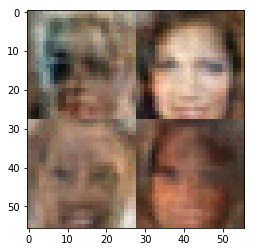

Epoch 2/30... Discriminator Loss: 1.5480... Generator Loss: 0.3010
Epoch 2/30... Discriminator Loss: 0.8666... Generator Loss: 3.4834
Epoch 2/30... Discriminator Loss: 0.5897... Generator Loss: 0.9560
Epoch 2/30... Discriminator Loss: 0.1872... Generator Loss: 4.0544
Epoch 2/30... Discriminator Loss: 0.3398... Generator Loss: 2.0239
Epoch 2/30... Discriminator Loss: 3.0608... Generator Loss: 3.2568
Epoch 2/30... Discriminator Loss: 1.4730... Generator Loss: 0.7028
Epoch 2/30... Discriminator Loss: 0.9379... Generator Loss: 0.8150
Epoch 2/30... Discriminator Loss: 0.1553... Generator Loss: 2.5508
Epoch 2/30... Discriminator Loss: 0.1670... Generator Loss: 2.5486


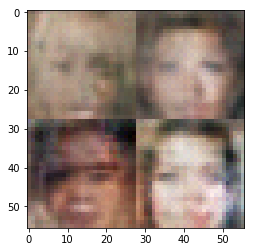

Epoch 2/30... Discriminator Loss: 0.0709... Generator Loss: 4.3576
Epoch 2/30... Discriminator Loss: 0.4561... Generator Loss: 6.9768
Epoch 2/30... Discriminator Loss: 0.2805... Generator Loss: 3.4723
Epoch 2/30... Discriminator Loss: 0.0153... Generator Loss: 6.5557
Epoch 2/30... Discriminator Loss: 0.0429... Generator Loss: 3.4669
Epoch 2/30... Discriminator Loss: 1.8936... Generator Loss: 0.2180
Epoch 2/30... Discriminator Loss: 0.7938... Generator Loss: 4.0350
Epoch 2/30... Discriminator Loss: 0.2108... Generator Loss: 3.0434
Epoch 2/30... Discriminator Loss: 0.0392... Generator Loss: 3.6808
Epoch 2/30... Discriminator Loss: 0.6758... Generator Loss: 0.9493


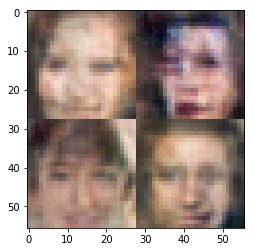

Epoch 2/30... Discriminator Loss: 0.1161... Generator Loss: 3.7310
Epoch 2/30... Discriminator Loss: 0.6851... Generator Loss: 1.7424
Epoch 2/30... Discriminator Loss: 1.1126... Generator Loss: 0.6592
Epoch 2/30... Discriminator Loss: 0.0758... Generator Loss: 4.1590
Epoch 2/30... Discriminator Loss: 0.8404... Generator Loss: 2.7026
Epoch 2/30... Discriminator Loss: 0.4679... Generator Loss: 1.2508
Epoch 2/30... Discriminator Loss: 0.1526... Generator Loss: 3.9098
Epoch 2/30... Discriminator Loss: 0.0136... Generator Loss: 6.9913
Epoch 2/30... Discriminator Loss: 1.5443... Generator Loss: 0.6578
Epoch 2/30... Discriminator Loss: 1.3290... Generator Loss: 0.9044


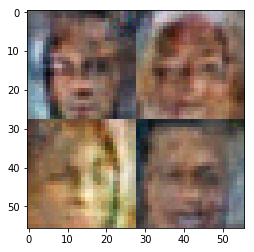

Epoch 2/30... Discriminator Loss: 1.1378... Generator Loss: 0.9359
Epoch 2/30... Discriminator Loss: 1.1842... Generator Loss: 0.9770
Epoch 2/30... Discriminator Loss: 0.9275... Generator Loss: 1.2385
Epoch 2/30... Discriminator Loss: 1.5230... Generator Loss: 3.6931
Epoch 2/30... Discriminator Loss: 0.0946... Generator Loss: 4.1295
Epoch 2/30... Discriminator Loss: 1.6321... Generator Loss: 0.3135
Epoch 2/30... Discriminator Loss: 0.0912... Generator Loss: 5.0246
Epoch 2/30... Discriminator Loss: 1.2103... Generator Loss: 0.4576
Epoch 2/30... Discriminator Loss: 0.5157... Generator Loss: 1.1388
Epoch 2/30... Discriminator Loss: 1.4070... Generator Loss: 2.5016


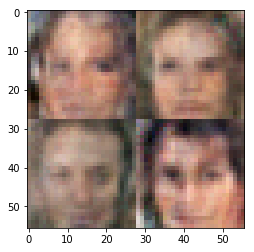

Epoch 2/30... Discriminator Loss: 0.2316... Generator Loss: 2.7025
Epoch 2/30... Discriminator Loss: 1.0703... Generator Loss: 0.8470
Epoch 2/30... Discriminator Loss: 0.1493... Generator Loss: 2.5549
Epoch 2/30... Discriminator Loss: 0.9616... Generator Loss: 0.6205
Epoch 2/30... Discriminator Loss: 0.7932... Generator Loss: 0.7420
Epoch 2/30... Discriminator Loss: 0.0671... Generator Loss: 4.7620
Epoch 2/30... Discriminator Loss: 0.9081... Generator Loss: 2.8569
Epoch 2/30... Discriminator Loss: 0.1465... Generator Loss: 2.4164
Epoch 2/30... Discriminator Loss: 0.1883... Generator Loss: 2.7911
Epoch 2/30... Discriminator Loss: 0.1518... Generator Loss: 4.2862


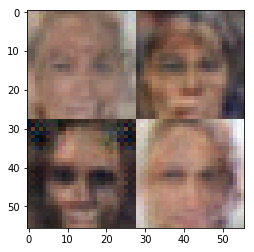

Epoch 2/30... Discriminator Loss: 2.2370... Generator Loss: 8.1488
Epoch 2/30... Discriminator Loss: 0.9091... Generator Loss: 0.7714
Epoch 2/30... Discriminator Loss: 0.2334... Generator Loss: 4.1444
Epoch 2/30... Discriminator Loss: 0.3255... Generator Loss: 1.9153
Epoch 2/30... Discriminator Loss: 0.1682... Generator Loss: 2.3037
Epoch 2/30... Discriminator Loss: 0.0628... Generator Loss: 5.9120
Epoch 2/30... Discriminator Loss: 0.0136... Generator Loss: 6.7220
Epoch 2/30... Discriminator Loss: 0.0157... Generator Loss: 4.8364
Epoch 2/30... Discriminator Loss: 0.0184... Generator Loss: 4.2926
Epoch 2/30... Discriminator Loss: 0.0205... Generator Loss: 4.1710


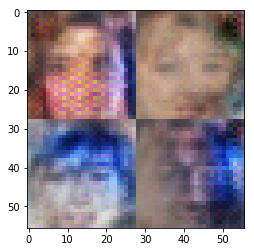

Epoch 2/30... Discriminator Loss: 0.0206... Generator Loss: 4.1997
Epoch 2/30... Discriminator Loss: 0.0207... Generator Loss: 4.1709
Epoch 2/30... Discriminator Loss: 0.0195... Generator Loss: 4.3310
Epoch 2/30... Discriminator Loss: 0.0176... Generator Loss: 4.3744
Epoch 2/30... Discriminator Loss: 0.0143... Generator Loss: 4.6611
Epoch 2/30... Discriminator Loss: 0.0111... Generator Loss: 4.8597
Epoch 2/30... Discriminator Loss: 0.0132... Generator Loss: 4.6929
Epoch 2/30... Discriminator Loss: 0.0168... Generator Loss: 4.3830
Epoch 2/30... Discriminator Loss: 0.0128... Generator Loss: 4.6511
Epoch 2/30... Discriminator Loss: 0.0119... Generator Loss: 4.7678


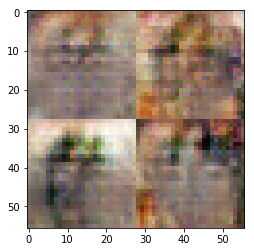

Epoch 2/30... Discriminator Loss: 0.0168... Generator Loss: 4.3368
Epoch 2/30... Discriminator Loss: 0.0192... Generator Loss: 4.2335
Epoch 2/30... Discriminator Loss: 0.0209... Generator Loss: 4.0819
Epoch 2/30... Discriminator Loss: 0.0180... Generator Loss: 4.2517
Epoch 2/30... Discriminator Loss: 0.0157... Generator Loss: 4.4665
Epoch 2/30... Discriminator Loss: 0.0167... Generator Loss: 4.3636
Epoch 2/30... Discriminator Loss: 0.0123... Generator Loss: 4.6281
Epoch 2/30... Discriminator Loss: 0.0217... Generator Loss: 4.2756
Epoch 2/30... Discriminator Loss: 0.0116... Generator Loss: 4.9320
Epoch 2/30... Discriminator Loss: 0.0328... Generator Loss: 3.7322


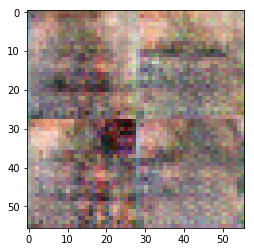

Epoch 2/30... Discriminator Loss: 0.0271... Generator Loss: 3.8084
Epoch 2/30... Discriminator Loss: 0.0176... Generator Loss: 4.2514
Epoch 2/30... Discriminator Loss: 0.0128... Generator Loss: 4.5413
Epoch 2/30... Discriminator Loss: 0.0147... Generator Loss: 4.3919
Epoch 2/30... Discriminator Loss: 0.0232... Generator Loss: 3.9100
Epoch 2/30... Discriminator Loss: 0.0178... Generator Loss: 4.1977
Epoch 2/30... Discriminator Loss: 0.0103... Generator Loss: 4.7991
Epoch 2/30... Discriminator Loss: 0.0145... Generator Loss: 4.4225
Epoch 2/30... Discriminator Loss: 0.0201... Generator Loss: 4.0227
Epoch 2/30... Discriminator Loss: 0.0156... Generator Loss: 4.2715


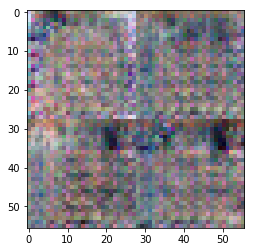

Epoch 2/30... Discriminator Loss: 0.0096... Generator Loss: 4.8151
Epoch 2/30... Discriminator Loss: 0.0065... Generator Loss: 5.2685
Epoch 2/30... Discriminator Loss: 0.0093... Generator Loss: 4.8357
Epoch 2/30... Discriminator Loss: 0.0075... Generator Loss: 5.0564
Epoch 2/30... Discriminator Loss: 0.0078... Generator Loss: 5.0294
Epoch 2/30... Discriminator Loss: 0.0042... Generator Loss: 5.6752
Epoch 2/30... Discriminator Loss: 0.0141... Generator Loss: 4.4803
Epoch 2/30... Discriminator Loss: 0.0196... Generator Loss: 4.0134
Epoch 2/30... Discriminator Loss: 0.0186... Generator Loss: 4.0613
Epoch 2/30... Discriminator Loss: 0.0113... Generator Loss: 4.6640


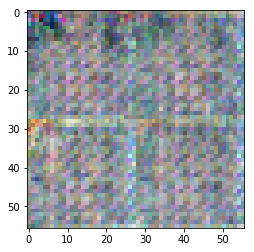

Epoch 2/30... Discriminator Loss: 0.0098... Generator Loss: 4.7174
Epoch 2/30... Discriminator Loss: 0.0072... Generator Loss: 5.0854
Epoch 2/30... Discriminator Loss: 0.0094... Generator Loss: 4.8128
Epoch 2/30... Discriminator Loss: 0.0078... Generator Loss: 5.0111
Epoch 2/30... Discriminator Loss: 0.0031... Generator Loss: 6.0936
Epoch 2/30... Discriminator Loss: 0.0094... Generator Loss: 4.8335
Epoch 2/30... Discriminator Loss: 0.0037... Generator Loss: 5.7729
Epoch 2/30... Discriminator Loss: 0.0078... Generator Loss: 5.1830
Epoch 2/30... Discriminator Loss: 0.0046... Generator Loss: 5.5391
Epoch 2/30... Discriminator Loss: 0.0062... Generator Loss: 5.1690


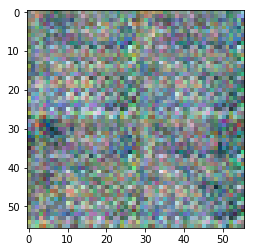

Epoch 2/30... Discriminator Loss: 0.0042... Generator Loss: 5.5837
Epoch 2/30... Discriminator Loss: 0.0068... Generator Loss: 5.0878
Epoch 2/30... Discriminator Loss: 0.0044... Generator Loss: 5.5726
Epoch 2/30... Discriminator Loss: 0.0045... Generator Loss: 5.5172
Epoch 2/30... Discriminator Loss: 0.0007... Generator Loss: 8.3452
Epoch 2/30... Discriminator Loss: 0.0024... Generator Loss: 6.4388
Epoch 2/30... Discriminator Loss: 0.0074... Generator Loss: 5.0736
Epoch 2/30... Discriminator Loss: 0.0030... Generator Loss: 6.2415
Epoch 2/30... Discriminator Loss: 0.0051... Generator Loss: 5.5108
Epoch 2/30... Discriminator Loss: 0.0088... Generator Loss: 4.9326


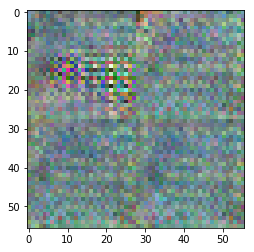

Epoch 2/30... Discriminator Loss: 0.0052... Generator Loss: 5.7401
Epoch 2/30... Discriminator Loss: 0.0105... Generator Loss: 4.7916
Epoch 2/30... Discriminator Loss: 0.0064... Generator Loss: 5.3982
Epoch 2/30... Discriminator Loss: 0.0023... Generator Loss: 6.5668
Epoch 2/30... Discriminator Loss: 0.0062... Generator Loss: 5.3851
Epoch 2/30... Discriminator Loss: 0.0055... Generator Loss: 5.4593
Epoch 2/30... Discriminator Loss: 0.0073... Generator Loss: 5.1253
Epoch 2/30... Discriminator Loss: 0.0070... Generator Loss: 5.1846
Epoch 2/30... Discriminator Loss: 0.0081... Generator Loss: 5.0026
Epoch 2/30... Discriminator Loss: 0.0031... Generator Loss: 5.9569


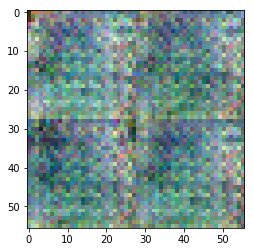

Epoch 2/30... Discriminator Loss: 0.0069... Generator Loss: 5.1260
Epoch 2/30... Discriminator Loss: 0.0019... Generator Loss: 6.4936
Epoch 2/30... Discriminator Loss: 0.0022... Generator Loss: 6.3133
Epoch 2/30... Discriminator Loss: 0.0036... Generator Loss: 5.7686
Epoch 2/30... Discriminator Loss: 0.0004... Generator Loss: 9.0542
Epoch 2/30... Discriminator Loss: 0.0025... Generator Loss: 6.3027
Epoch 2/30... Discriminator Loss: 0.0055... Generator Loss: 5.4602
Epoch 2/30... Discriminator Loss: 0.0047... Generator Loss: 5.5525
Epoch 2/30... Discriminator Loss: 0.0020... Generator Loss: 6.4527
Epoch 2/30... Discriminator Loss: 0.0090... Generator Loss: 4.9812


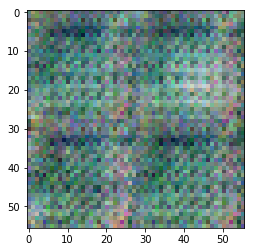

Epoch 2/30... Discriminator Loss: 0.0065... Generator Loss: 5.2598
Epoch 2/30... Discriminator Loss: 0.0049... Generator Loss: 5.5356
Epoch 2/30... Discriminator Loss: 0.0033... Generator Loss: 5.9260
Epoch 2/30... Discriminator Loss: 0.0036... Generator Loss: 5.8354
Epoch 2/30... Discriminator Loss: 0.0014... Generator Loss: 6.8165
Epoch 2/30... Discriminator Loss: 0.0034... Generator Loss: 5.8599
epoch_i 2
Epoch 3/30... Discriminator Loss: 0.0026... Generator Loss: 6.2715
Epoch 3/30... Discriminator Loss: 0.0026... Generator Loss: 6.2772
Epoch 3/30... Discriminator Loss: 0.0014... Generator Loss: 6.8065
Epoch 3/30... Discriminator Loss: 0.0017... Generator Loss: 6.7188


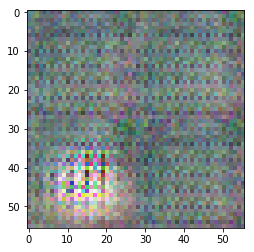

Epoch 3/30... Discriminator Loss: 0.0014... Generator Loss: 6.9351
Epoch 3/30... Discriminator Loss: 0.0049... Generator Loss: 5.6132
Epoch 3/30... Discriminator Loss: 0.0039... Generator Loss: 5.8217
Epoch 3/30... Discriminator Loss: 0.0035... Generator Loss: 5.8336
Epoch 3/30... Discriminator Loss: 0.0044... Generator Loss: 5.6414
Epoch 3/30... Discriminator Loss: 0.0040... Generator Loss: 5.7791
Epoch 3/30... Discriminator Loss: 0.0053... Generator Loss: 5.4388
Epoch 3/30... Discriminator Loss: 0.0032... Generator Loss: 5.8911
Epoch 3/30... Discriminator Loss: 0.0019... Generator Loss: 6.4509
Epoch 3/30... Discriminator Loss: 0.0044... Generator Loss: 5.5962


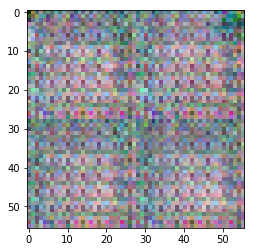

Epoch 3/30... Discriminator Loss: 0.0038... Generator Loss: 5.7929
Epoch 3/30... Discriminator Loss: 0.0023... Generator Loss: 6.3219
Epoch 3/30... Discriminator Loss: 0.0029... Generator Loss: 6.0555
Epoch 3/30... Discriminator Loss: 0.0023... Generator Loss: 6.3681
Epoch 3/30... Discriminator Loss: 0.0023... Generator Loss: 6.3578
Epoch 3/30... Discriminator Loss: 0.0026... Generator Loss: 6.3835
Epoch 3/30... Discriminator Loss: 0.0003... Generator Loss: 9.0753
Epoch 3/30... Discriminator Loss: 0.0018... Generator Loss: 6.6169
Epoch 3/30... Discriminator Loss: 0.0024... Generator Loss: 6.3966
Epoch 3/30... Discriminator Loss: 0.0018... Generator Loss: 6.7780


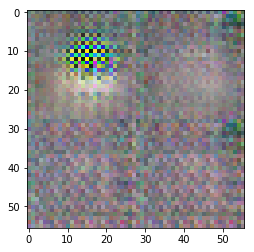

Epoch 3/30... Discriminator Loss: 0.0015... Generator Loss: 6.9300
Epoch 3/30... Discriminator Loss: 0.0024... Generator Loss: 6.4713
Epoch 3/30... Discriminator Loss: 0.0021... Generator Loss: 6.6284
Epoch 3/30... Discriminator Loss: 0.0006... Generator Loss: 8.1328
Epoch 3/30... Discriminator Loss: 0.0012... Generator Loss: 7.3671
Epoch 3/30... Discriminator Loss: 0.0024... Generator Loss: 6.6101
Epoch 3/30... Discriminator Loss: 0.0006... Generator Loss: 8.2500
Epoch 3/30... Discriminator Loss: 0.0024... Generator Loss: 6.5998
Epoch 3/30... Discriminator Loss: 0.0030... Generator Loss: 6.4534
Epoch 3/30... Discriminator Loss: 0.0008... Generator Loss: 7.6790


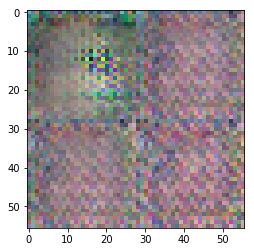

Epoch 3/30... Discriminator Loss: 0.0011... Generator Loss: 7.3672
Epoch 3/30... Discriminator Loss: 0.0012... Generator Loss: 7.2463
Epoch 3/30... Discriminator Loss: 0.0009... Generator Loss: 7.3180
Epoch 3/30... Discriminator Loss: 0.0008... Generator Loss: 8.1469
Epoch 3/30... Discriminator Loss: 0.0045... Generator Loss: 11.5062
Epoch 3/30... Discriminator Loss: 0.0017... Generator Loss: 12.8838
Epoch 3/30... Discriminator Loss: 0.0013... Generator Loss: 9.8822
Epoch 3/30... Discriminator Loss: 0.0011... Generator Loss: 8.4523
Epoch 3/30... Discriminator Loss: 0.0026... Generator Loss: 8.7284
Epoch 3/30... Discriminator Loss: 0.0019... Generator Loss: 7.7444


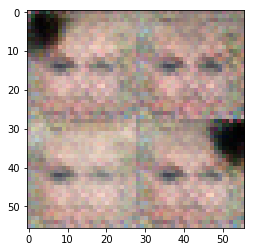

Epoch 3/30... Discriminator Loss: 0.0020... Generator Loss: 8.3040
Epoch 3/30... Discriminator Loss: 0.0008... Generator Loss: 12.2373
Epoch 3/30... Discriminator Loss: 3.1810... Generator Loss: 10.5134
Epoch 3/30... Discriminator Loss: 1.1644... Generator Loss: 1.3975
Epoch 3/30... Discriminator Loss: 0.6628... Generator Loss: 1.6373
Epoch 3/30... Discriminator Loss: 0.5134... Generator Loss: 1.8033
Epoch 3/30... Discriminator Loss: 1.0613... Generator Loss: 2.0108
Epoch 3/30... Discriminator Loss: 0.9697... Generator Loss: 0.8106
Epoch 3/30... Discriminator Loss: 0.8596... Generator Loss: 5.8427
Epoch 3/30... Discriminator Loss: 0.2833... Generator Loss: 2.5117


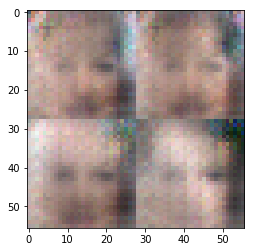

Epoch 3/30... Discriminator Loss: 0.7642... Generator Loss: 2.2289
Epoch 3/30... Discriminator Loss: 0.3875... Generator Loss: 2.2330
Epoch 3/30... Discriminator Loss: 0.5287... Generator Loss: 2.9108
Epoch 3/30... Discriminator Loss: 0.5763... Generator Loss: 3.4092
Epoch 3/30... Discriminator Loss: 0.8395... Generator Loss: 0.8872
Epoch 3/30... Discriminator Loss: 1.2406... Generator Loss: 0.5695
Epoch 3/30... Discriminator Loss: 0.1855... Generator Loss: 3.2255
Epoch 3/30... Discriminator Loss: 0.2687... Generator Loss: 2.4107
Epoch 3/30... Discriminator Loss: 0.4766... Generator Loss: 5.1107
Epoch 3/30... Discriminator Loss: 1.3663... Generator Loss: 5.2418


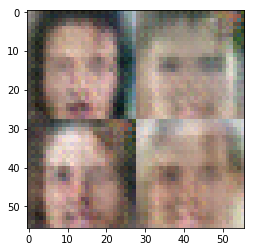

Epoch 3/30... Discriminator Loss: 0.8249... Generator Loss: 0.9968
Epoch 3/30... Discriminator Loss: 0.2880... Generator Loss: 2.2407
Epoch 3/30... Discriminator Loss: 0.2543... Generator Loss: 3.3545
Epoch 3/30... Discriminator Loss: 0.4500... Generator Loss: 2.9408
Epoch 3/30... Discriminator Loss: 0.4731... Generator Loss: 1.4606
Epoch 3/30... Discriminator Loss: 0.2404... Generator Loss: 2.7193
Epoch 3/30... Discriminator Loss: 0.2547... Generator Loss: 6.4517
Epoch 3/30... Discriminator Loss: 0.1145... Generator Loss: 3.1318
Epoch 3/30... Discriminator Loss: 0.2924... Generator Loss: 2.1235
Epoch 3/30... Discriminator Loss: 0.1132... Generator Loss: 3.1094


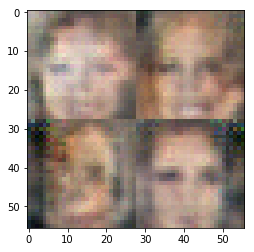

Epoch 3/30... Discriminator Loss: 0.3216... Generator Loss: 2.1941
Epoch 3/30... Discriminator Loss: 0.2027... Generator Loss: 2.9438
Epoch 3/30... Discriminator Loss: 0.6077... Generator Loss: 1.2405
Epoch 3/30... Discriminator Loss: 1.2274... Generator Loss: 0.5362
Epoch 3/30... Discriminator Loss: 1.2610... Generator Loss: 4.6045
Epoch 3/30... Discriminator Loss: 0.1435... Generator Loss: 4.1652
Epoch 3/30... Discriminator Loss: 1.6686... Generator Loss: 5.5479
Epoch 3/30... Discriminator Loss: 0.2597... Generator Loss: 2.2233
Epoch 3/30... Discriminator Loss: 0.4586... Generator Loss: 1.4152
Epoch 3/30... Discriminator Loss: 0.5420... Generator Loss: 3.7291


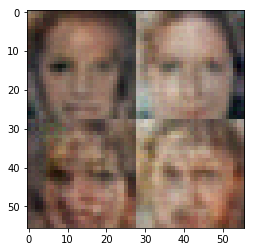

Epoch 3/30... Discriminator Loss: 4.5592... Generator Loss: 5.1744
Epoch 3/30... Discriminator Loss: 0.3930... Generator Loss: 1.8237
Epoch 3/30... Discriminator Loss: 0.5989... Generator Loss: 1.5618
Epoch 3/30... Discriminator Loss: 0.4582... Generator Loss: 2.4397
Epoch 3/30... Discriminator Loss: 0.1483... Generator Loss: 2.9168
Epoch 3/30... Discriminator Loss: 1.7074... Generator Loss: 0.2926
Epoch 3/30... Discriminator Loss: 1.2210... Generator Loss: 0.8812
Epoch 3/30... Discriminator Loss: 2.3451... Generator Loss: 0.1675
Epoch 3/30... Discriminator Loss: 0.6300... Generator Loss: 1.3930
Epoch 3/30... Discriminator Loss: 0.2985... Generator Loss: 1.9306


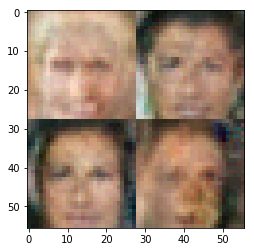

Epoch 3/30... Discriminator Loss: 0.3192... Generator Loss: 1.7782
Epoch 3/30... Discriminator Loss: 0.4605... Generator Loss: 1.3348
Epoch 3/30... Discriminator Loss: 0.1623... Generator Loss: 2.5234
Epoch 3/30... Discriminator Loss: 1.1002... Generator Loss: 1.1718
Epoch 3/30... Discriminator Loss: 0.8052... Generator Loss: 0.8453
Epoch 3/30... Discriminator Loss: 0.1381... Generator Loss: 2.5796
Epoch 3/30... Discriminator Loss: 0.1175... Generator Loss: 3.1047
Epoch 3/30... Discriminator Loss: 0.2573... Generator Loss: 4.8890
Epoch 3/30... Discriminator Loss: 0.0797... Generator Loss: 3.6595
Epoch 3/30... Discriminator Loss: 0.8057... Generator Loss: 1.9200


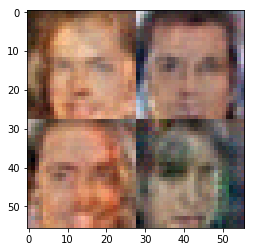

Epoch 3/30... Discriminator Loss: 0.1062... Generator Loss: 3.7776
Epoch 3/30... Discriminator Loss: 2.7672... Generator Loss: 5.1912
Epoch 3/30... Discriminator Loss: 0.4556... Generator Loss: 1.8129
Epoch 3/30... Discriminator Loss: 0.8763... Generator Loss: 0.6993
Epoch 3/30... Discriminator Loss: 1.4777... Generator Loss: 0.3729
Epoch 3/30... Discriminator Loss: 1.0337... Generator Loss: 2.0994
Epoch 3/30... Discriminator Loss: 0.2562... Generator Loss: 1.9242
Epoch 3/30... Discriminator Loss: 0.0521... Generator Loss: 4.3654
Epoch 3/30... Discriminator Loss: 0.1374... Generator Loss: 3.6733
Epoch 3/30... Discriminator Loss: 1.8309... Generator Loss: 0.2661


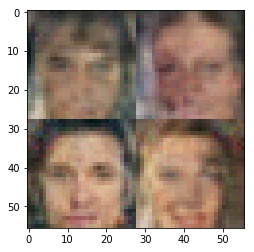

Epoch 3/30... Discriminator Loss: 1.1289... Generator Loss: 1.6544
Epoch 3/30... Discriminator Loss: 0.5135... Generator Loss: 1.3097
Epoch 3/30... Discriminator Loss: 1.3934... Generator Loss: 4.6029
Epoch 3/30... Discriminator Loss: 0.4889... Generator Loss: 4.3277
Epoch 3/30... Discriminator Loss: 0.6520... Generator Loss: 2.1524
Epoch 3/30... Discriminator Loss: 1.4748... Generator Loss: 2.6333
Epoch 3/30... Discriminator Loss: 0.6948... Generator Loss: 3.6495
Epoch 3/30... Discriminator Loss: 0.6461... Generator Loss: 1.0351
Epoch 3/30... Discriminator Loss: 0.8509... Generator Loss: 2.1219
Epoch 3/30... Discriminator Loss: 1.1194... Generator Loss: 2.8186


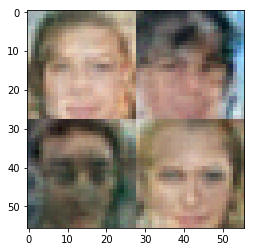

Epoch 3/30... Discriminator Loss: 0.3648... Generator Loss: 2.8596
Epoch 3/30... Discriminator Loss: 0.1286... Generator Loss: 3.0190
Epoch 3/30... Discriminator Loss: 0.6905... Generator Loss: 1.0084
Epoch 3/30... Discriminator Loss: 1.3741... Generator Loss: 0.4762
Epoch 3/30... Discriminator Loss: 0.8668... Generator Loss: 0.8153
Epoch 3/30... Discriminator Loss: 2.1563... Generator Loss: 5.3529
Epoch 3/30... Discriminator Loss: 0.4652... Generator Loss: 1.5602
Epoch 3/30... Discriminator Loss: 0.5257... Generator Loss: 1.1235
Epoch 3/30... Discriminator Loss: 0.4304... Generator Loss: 2.6873
Epoch 3/30... Discriminator Loss: 0.3810... Generator Loss: 1.8860


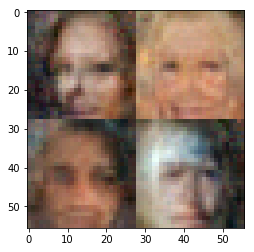

Epoch 3/30... Discriminator Loss: 0.3734... Generator Loss: 2.5987
Epoch 3/30... Discriminator Loss: 0.5721... Generator Loss: 1.0974
Epoch 3/30... Discriminator Loss: 0.1672... Generator Loss: 2.3399
Epoch 3/30... Discriminator Loss: 1.2591... Generator Loss: 0.4882
Epoch 3/30... Discriminator Loss: 0.7426... Generator Loss: 7.9017
Epoch 3/30... Discriminator Loss: 2.4764... Generator Loss: 3.1478
Epoch 3/30... Discriminator Loss: 1.4371... Generator Loss: 2.9566
Epoch 3/30... Discriminator Loss: 1.5334... Generator Loss: 0.3541
Epoch 3/30... Discriminator Loss: 0.1612... Generator Loss: 3.1355
Epoch 3/30... Discriminator Loss: 0.6311... Generator Loss: 1.8163


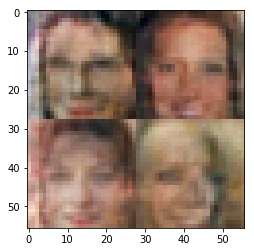

Epoch 3/30... Discriminator Loss: 0.3811... Generator Loss: 3.0314
Epoch 3/30... Discriminator Loss: 1.2441... Generator Loss: 0.8249
Epoch 3/30... Discriminator Loss: 0.5366... Generator Loss: 2.0859
Epoch 3/30... Discriminator Loss: 0.2340... Generator Loss: 2.0533
Epoch 3/30... Discriminator Loss: 0.9133... Generator Loss: 1.4872
Epoch 3/30... Discriminator Loss: 2.1075... Generator Loss: 2.1413
Epoch 3/30... Discriminator Loss: 0.1702... Generator Loss: 3.0193
Epoch 3/30... Discriminator Loss: 0.8191... Generator Loss: 1.0792
Epoch 3/30... Discriminator Loss: 0.0919... Generator Loss: 5.0137
Epoch 3/30... Discriminator Loss: 3.7106... Generator Loss: 4.4902


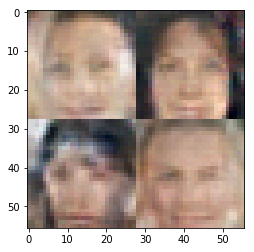

Epoch 3/30... Discriminator Loss: 0.8533... Generator Loss: 4.4007
Epoch 3/30... Discriminator Loss: 0.8429... Generator Loss: 0.7580
Epoch 3/30... Discriminator Loss: 0.3717... Generator Loss: 1.5738
Epoch 3/30... Discriminator Loss: 1.5448... Generator Loss: 0.3354
epoch_i 3
Epoch 4/30... Discriminator Loss: 1.1618... Generator Loss: 1.3582
Epoch 4/30... Discriminator Loss: 0.1019... Generator Loss: 3.5428
Epoch 4/30... Discriminator Loss: 0.0677... Generator Loss: 4.6680
Epoch 4/30... Discriminator Loss: 2.8164... Generator Loss: 3.3981
Epoch 4/30... Discriminator Loss: 0.5380... Generator Loss: 1.5933
Epoch 4/30... Discriminator Loss: 0.6034... Generator Loss: 1.0708


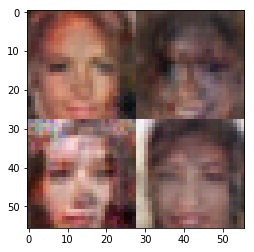

Epoch 4/30... Discriminator Loss: 0.9534... Generator Loss: 0.8237
Epoch 4/30... Discriminator Loss: 0.4857... Generator Loss: 1.7945
Epoch 4/30... Discriminator Loss: 0.1360... Generator Loss: 3.0553
Epoch 4/30... Discriminator Loss: 0.6494... Generator Loss: 0.9862
Epoch 4/30... Discriminator Loss: 0.6014... Generator Loss: 2.3004
Epoch 4/30... Discriminator Loss: 1.3583... Generator Loss: 0.4491
Epoch 4/30... Discriminator Loss: 0.1281... Generator Loss: 4.3693
Epoch 4/30... Discriminator Loss: 0.2831... Generator Loss: 3.2460
Epoch 4/30... Discriminator Loss: 0.1350... Generator Loss: 2.6449
Epoch 4/30... Discriminator Loss: 0.8805... Generator Loss: 1.1200


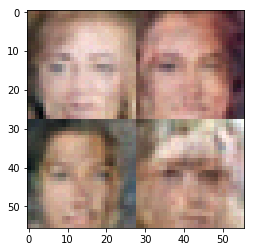

Epoch 4/30... Discriminator Loss: 1.7169... Generator Loss: 3.4564
Epoch 4/30... Discriminator Loss: 0.2620... Generator Loss: 2.4546
Epoch 4/30... Discriminator Loss: 0.6071... Generator Loss: 1.5276
Epoch 4/30... Discriminator Loss: 0.3914... Generator Loss: 1.8031
Epoch 4/30... Discriminator Loss: 1.2352... Generator Loss: 1.8345
Epoch 4/30... Discriminator Loss: 0.8972... Generator Loss: 2.1199
Epoch 4/30... Discriminator Loss: 0.5523... Generator Loss: 1.6514
Epoch 4/30... Discriminator Loss: 0.8676... Generator Loss: 0.9282
Epoch 4/30... Discriminator Loss: 0.8004... Generator Loss: 0.9342
Epoch 4/30... Discriminator Loss: 0.8509... Generator Loss: 0.8529


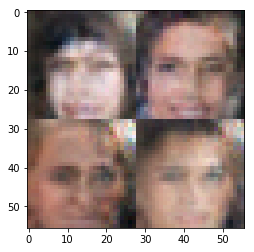

Epoch 4/30... Discriminator Loss: 1.1086... Generator Loss: 6.0403
Epoch 4/30... Discriminator Loss: 1.1626... Generator Loss: 0.5923
Epoch 4/30... Discriminator Loss: 0.3581... Generator Loss: 1.6793
Epoch 4/30... Discriminator Loss: 0.8429... Generator Loss: 1.4999
Epoch 4/30... Discriminator Loss: 0.5380... Generator Loss: 1.2407
Epoch 4/30... Discriminator Loss: 1.1621... Generator Loss: 1.7772
Epoch 4/30... Discriminator Loss: 0.5580... Generator Loss: 1.2677
Epoch 4/30... Discriminator Loss: 0.1314... Generator Loss: 3.1456
Epoch 4/30... Discriminator Loss: 1.6676... Generator Loss: 1.0765
Epoch 4/30... Discriminator Loss: 1.3749... Generator Loss: 0.4938


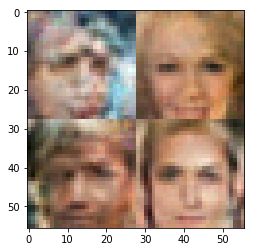

Epoch 4/30... Discriminator Loss: 1.2921... Generator Loss: 0.5875
Epoch 4/30... Discriminator Loss: 0.8511... Generator Loss: 1.2933
Epoch 4/30... Discriminator Loss: 0.8609... Generator Loss: 1.4838
Epoch 4/30... Discriminator Loss: 0.4482... Generator Loss: 1.4969
Epoch 4/30... Discriminator Loss: 1.5864... Generator Loss: 3.3909
Epoch 4/30... Discriminator Loss: 0.5349... Generator Loss: 1.2109
Epoch 4/30... Discriminator Loss: 1.1275... Generator Loss: 0.7301
Epoch 4/30... Discriminator Loss: 0.6277... Generator Loss: 3.0842
Epoch 4/30... Discriminator Loss: 0.2392... Generator Loss: 2.4537
Epoch 4/30... Discriminator Loss: 0.5596... Generator Loss: 1.3706


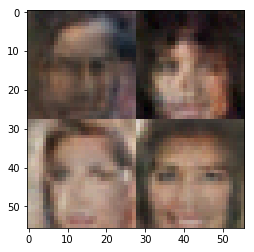

Epoch 4/30... Discriminator Loss: 0.8910... Generator Loss: 0.6705
Epoch 4/30... Discriminator Loss: 0.9660... Generator Loss: 0.7527
Epoch 4/30... Discriminator Loss: 0.7068... Generator Loss: 1.3203
Epoch 4/30... Discriminator Loss: 0.1456... Generator Loss: 4.7377
Epoch 4/30... Discriminator Loss: 1.2161... Generator Loss: 3.4021
Epoch 4/30... Discriminator Loss: 0.2981... Generator Loss: 2.5028
Epoch 4/30... Discriminator Loss: 0.5133... Generator Loss: 3.1734
Epoch 4/30... Discriminator Loss: 0.2626... Generator Loss: 2.4792
Epoch 4/30... Discriminator Loss: 1.0478... Generator Loss: 3.6902
Epoch 4/30... Discriminator Loss: 0.8653... Generator Loss: 1.2142


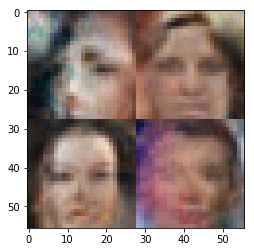

Epoch 4/30... Discriminator Loss: 1.6980... Generator Loss: 0.2928
Epoch 4/30... Discriminator Loss: 0.8852... Generator Loss: 0.7187
Epoch 4/30... Discriminator Loss: 0.9394... Generator Loss: 0.9534
Epoch 4/30... Discriminator Loss: 0.3816... Generator Loss: 4.4804
Epoch 4/30... Discriminator Loss: 0.5091... Generator Loss: 1.7141
Epoch 4/30... Discriminator Loss: 0.2802... Generator Loss: 1.8641
Epoch 4/30... Discriminator Loss: 0.5805... Generator Loss: 1.6310
Epoch 4/30... Discriminator Loss: 0.2375... Generator Loss: 2.6212
Epoch 4/30... Discriminator Loss: 0.9558... Generator Loss: 1.1406
Epoch 4/30... Discriminator Loss: 0.1857... Generator Loss: 3.2652


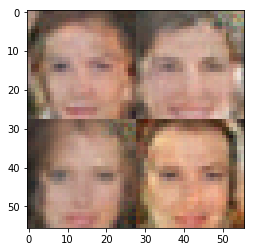

Epoch 4/30... Discriminator Loss: 1.8095... Generator Loss: 1.6033
Epoch 4/30... Discriminator Loss: 0.6225... Generator Loss: 3.3912
Epoch 4/30... Discriminator Loss: 0.6703... Generator Loss: 0.9707
Epoch 4/30... Discriminator Loss: 0.9016... Generator Loss: 1.7821
Epoch 4/30... Discriminator Loss: 0.2873... Generator Loss: 3.7346
Epoch 4/30... Discriminator Loss: 0.1545... Generator Loss: 2.7866
Epoch 4/30... Discriminator Loss: 1.7443... Generator Loss: 3.6232
Epoch 4/30... Discriminator Loss: 0.3705... Generator Loss: 3.0937
Epoch 4/30... Discriminator Loss: 1.7272... Generator Loss: 3.1009
Epoch 4/30... Discriminator Loss: 0.4312... Generator Loss: 1.9608


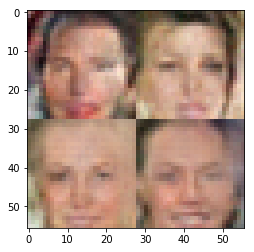

Epoch 4/30... Discriminator Loss: 1.1289... Generator Loss: 2.9489
Epoch 4/30... Discriminator Loss: 1.0689... Generator Loss: 0.6220
Epoch 4/30... Discriminator Loss: 1.0226... Generator Loss: 0.5883
Epoch 4/30... Discriminator Loss: 0.3801... Generator Loss: 1.6058
Epoch 4/30... Discriminator Loss: 0.9385... Generator Loss: 1.3300
Epoch 4/30... Discriminator Loss: 0.7963... Generator Loss: 0.8213
Epoch 4/30... Discriminator Loss: 0.1420... Generator Loss: 4.0406
Epoch 4/30... Discriminator Loss: 1.3338... Generator Loss: 0.6952
Epoch 4/30... Discriminator Loss: 0.7988... Generator Loss: 3.0029
Epoch 4/30... Discriminator Loss: 2.0606... Generator Loss: 0.1836


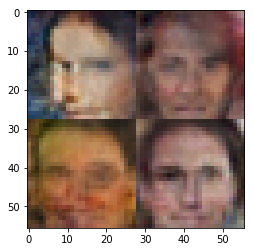

Epoch 4/30... Discriminator Loss: 1.1655... Generator Loss: 2.7513
Epoch 4/30... Discriminator Loss: 0.2619... Generator Loss: 2.2646
Epoch 4/30... Discriminator Loss: 0.7298... Generator Loss: 1.9179
Epoch 4/30... Discriminator Loss: 0.5070... Generator Loss: 1.7462
Epoch 4/30... Discriminator Loss: 1.2313... Generator Loss: 0.4992
Epoch 4/30... Discriminator Loss: 1.4760... Generator Loss: 3.8542
Epoch 4/30... Discriminator Loss: 0.2663... Generator Loss: 2.2844
Epoch 4/30... Discriminator Loss: 0.4057... Generator Loss: 1.5977
Epoch 4/30... Discriminator Loss: 0.6856... Generator Loss: 0.9387
Epoch 4/30... Discriminator Loss: 0.1825... Generator Loss: 3.4584


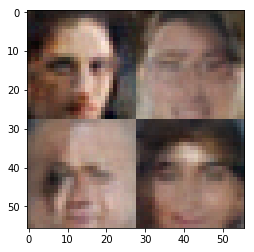

Epoch 4/30... Discriminator Loss: 1.1809... Generator Loss: 1.0264
Epoch 4/30... Discriminator Loss: 0.8493... Generator Loss: 0.9828
Epoch 4/30... Discriminator Loss: 0.6146... Generator Loss: 1.9821
Epoch 4/30... Discriminator Loss: 0.6402... Generator Loss: 1.6946
Epoch 4/30... Discriminator Loss: 1.4038... Generator Loss: 2.3998
Epoch 4/30... Discriminator Loss: 0.8402... Generator Loss: 0.8344
Epoch 4/30... Discriminator Loss: 0.6695... Generator Loss: 1.6909
Epoch 4/30... Discriminator Loss: 0.2307... Generator Loss: 2.5632
Epoch 4/30... Discriminator Loss: 1.1542... Generator Loss: 0.5713
Epoch 4/30... Discriminator Loss: 0.4269... Generator Loss: 2.0247


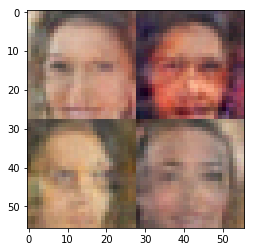

Epoch 4/30... Discriminator Loss: 1.4226... Generator Loss: 0.4064
Epoch 4/30... Discriminator Loss: 0.8726... Generator Loss: 1.3350
Epoch 4/30... Discriminator Loss: 1.1148... Generator Loss: 0.8493
Epoch 4/30... Discriminator Loss: 0.4859... Generator Loss: 3.4627
Epoch 4/30... Discriminator Loss: 0.4501... Generator Loss: 1.9381
Epoch 4/30... Discriminator Loss: 0.9848... Generator Loss: 1.5156
Epoch 4/30... Discriminator Loss: 0.8189... Generator Loss: 1.9936
Epoch 4/30... Discriminator Loss: 0.4579... Generator Loss: 1.3672
Epoch 4/30... Discriminator Loss: 0.9481... Generator Loss: 0.7460
Epoch 4/30... Discriminator Loss: 0.9455... Generator Loss: 1.1884


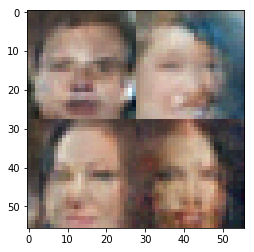

Epoch 4/30... Discriminator Loss: 1.6805... Generator Loss: 0.3372
Epoch 4/30... Discriminator Loss: 1.3704... Generator Loss: 2.8151
Epoch 4/30... Discriminator Loss: 0.9464... Generator Loss: 0.6973
Epoch 4/30... Discriminator Loss: 0.5962... Generator Loss: 1.4412
Epoch 4/30... Discriminator Loss: 0.6653... Generator Loss: 2.0353
Epoch 4/30... Discriminator Loss: 0.7470... Generator Loss: 1.1864
Epoch 4/30... Discriminator Loss: 0.6811... Generator Loss: 1.5623
Epoch 4/30... Discriminator Loss: 0.7195... Generator Loss: 1.8835
Epoch 4/30... Discriminator Loss: 0.4143... Generator Loss: 1.6923
Epoch 4/30... Discriminator Loss: 2.0254... Generator Loss: 3.9936


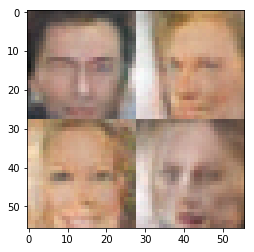

Epoch 4/30... Discriminator Loss: 0.3662... Generator Loss: 4.6578
Epoch 4/30... Discriminator Loss: 0.7814... Generator Loss: 0.8680
Epoch 4/30... Discriminator Loss: 1.4102... Generator Loss: 0.4378
Epoch 4/30... Discriminator Loss: 1.0083... Generator Loss: 0.6066
Epoch 4/30... Discriminator Loss: 0.7703... Generator Loss: 1.1025
Epoch 4/30... Discriminator Loss: 0.5799... Generator Loss: 1.1081
Epoch 4/30... Discriminator Loss: 1.0387... Generator Loss: 0.8352
Epoch 4/30... Discriminator Loss: 0.4518... Generator Loss: 1.3462
Epoch 4/30... Discriminator Loss: 0.7580... Generator Loss: 1.2231
Epoch 4/30... Discriminator Loss: 0.3197... Generator Loss: 2.9910


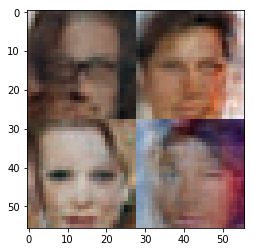

Epoch 4/30... Discriminator Loss: 0.2048... Generator Loss: 3.3412
Epoch 4/30... Discriminator Loss: 0.6811... Generator Loss: 0.9011
Epoch 4/30... Discriminator Loss: 0.5298... Generator Loss: 1.3201
Epoch 4/30... Discriminator Loss: 0.7837... Generator Loss: 0.9664
Epoch 4/30... Discriminator Loss: 0.7458... Generator Loss: 1.7781
Epoch 4/30... Discriminator Loss: 1.3074... Generator Loss: 4.9635
Epoch 4/30... Discriminator Loss: 1.2549... Generator Loss: 1.2362
Epoch 4/30... Discriminator Loss: 0.7772... Generator Loss: 1.8221
Epoch 4/30... Discriminator Loss: 0.5864... Generator Loss: 2.3002
Epoch 4/30... Discriminator Loss: 0.8560... Generator Loss: 0.9894


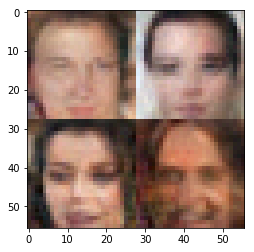

Epoch 4/30... Discriminator Loss: 0.1517... Generator Loss: 3.9922
Epoch 4/30... Discriminator Loss: 0.8646... Generator Loss: 3.1728
Epoch 4/30... Discriminator Loss: 1.2362... Generator Loss: 1.7691
Epoch 4/30... Discriminator Loss: 1.6937... Generator Loss: 3.0175
Epoch 4/30... Discriminator Loss: 0.4277... Generator Loss: 1.5009
Epoch 4/30... Discriminator Loss: 0.7848... Generator Loss: 1.9695
Epoch 4/30... Discriminator Loss: 0.6957... Generator Loss: 3.0802
Epoch 4/30... Discriminator Loss: 0.0714... Generator Loss: 4.8502
Epoch 4/30... Discriminator Loss: 0.0796... Generator Loss: 4.8263
Epoch 4/30... Discriminator Loss: 1.3238... Generator Loss: 0.7155


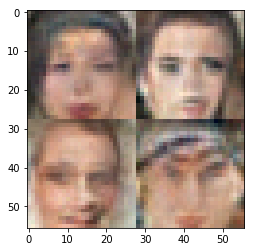

Epoch 4/30... Discriminator Loss: 0.6095... Generator Loss: 1.9368
Epoch 4/30... Discriminator Loss: 1.7191... Generator Loss: 2.3481
epoch_i 4
Epoch 5/30... Discriminator Loss: 0.7201... Generator Loss: 0.9246
Epoch 5/30... Discriminator Loss: 0.3538... Generator Loss: 1.8914
Epoch 5/30... Discriminator Loss: 0.2474... Generator Loss: 3.7246
Epoch 5/30... Discriminator Loss: 1.0133... Generator Loss: 2.2755
Epoch 5/30... Discriminator Loss: 1.1479... Generator Loss: 0.5422
Epoch 5/30... Discriminator Loss: 0.3766... Generator Loss: 1.8599
Epoch 5/30... Discriminator Loss: 0.6375... Generator Loss: 1.0222
Epoch 5/30... Discriminator Loss: 1.9871... Generator Loss: 1.7226


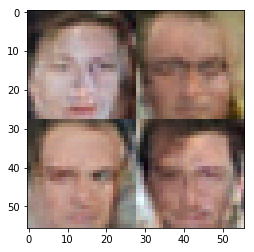

Epoch 5/30... Discriminator Loss: 0.3614... Generator Loss: 1.9248
Epoch 5/30... Discriminator Loss: 1.0800... Generator Loss: 0.5822
Epoch 5/30... Discriminator Loss: 0.5882... Generator Loss: 4.0775
Epoch 5/30... Discriminator Loss: 0.4934... Generator Loss: 1.6943
Epoch 5/30... Discriminator Loss: 1.2066... Generator Loss: 4.1460
Epoch 5/30... Discriminator Loss: 1.3943... Generator Loss: 2.8130
Epoch 5/30... Discriminator Loss: 0.1934... Generator Loss: 2.4802
Epoch 5/30... Discriminator Loss: 0.6542... Generator Loss: 1.0755
Epoch 5/30... Discriminator Loss: 0.6668... Generator Loss: 3.9764
Epoch 5/30... Discriminator Loss: 0.6216... Generator Loss: 1.4469


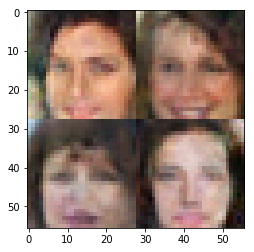

Epoch 5/30... Discriminator Loss: 0.1945... Generator Loss: 2.3696
Epoch 5/30... Discriminator Loss: 0.9766... Generator Loss: 1.4094
Epoch 5/30... Discriminator Loss: 0.6235... Generator Loss: 1.5155
Epoch 5/30... Discriminator Loss: 1.1879... Generator Loss: 0.5355
Epoch 5/30... Discriminator Loss: 0.7575... Generator Loss: 1.5975
Epoch 5/30... Discriminator Loss: 0.6092... Generator Loss: 1.1344
Epoch 5/30... Discriminator Loss: 1.5557... Generator Loss: 2.6143
Epoch 5/30... Discriminator Loss: 0.6244... Generator Loss: 1.1210
Epoch 5/30... Discriminator Loss: 0.6217... Generator Loss: 2.7269
Epoch 5/30... Discriminator Loss: 0.6322... Generator Loss: 1.3288


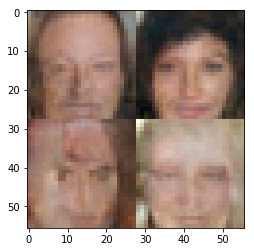

Epoch 5/30... Discriminator Loss: 0.8917... Generator Loss: 2.4354
Epoch 5/30... Discriminator Loss: 1.3081... Generator Loss: 1.7925
Epoch 5/30... Discriminator Loss: 0.4979... Generator Loss: 2.5087
Epoch 5/30... Discriminator Loss: 0.7439... Generator Loss: 1.0741
Epoch 5/30... Discriminator Loss: 0.4692... Generator Loss: 1.3749
Epoch 5/30... Discriminator Loss: 1.2744... Generator Loss: 2.2616
Epoch 5/30... Discriminator Loss: 0.3571... Generator Loss: 2.5171
Epoch 5/30... Discriminator Loss: 0.4646... Generator Loss: 4.8025
Epoch 5/30... Discriminator Loss: 1.7769... Generator Loss: 0.3101
Epoch 5/30... Discriminator Loss: 0.3921... Generator Loss: 1.9583


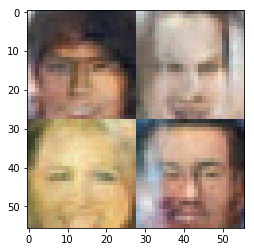

Epoch 5/30... Discriminator Loss: 0.5764... Generator Loss: 1.3371
Epoch 5/30... Discriminator Loss: 0.6988... Generator Loss: 0.9689
Epoch 5/30... Discriminator Loss: 1.0663... Generator Loss: 2.5283
Epoch 5/30... Discriminator Loss: 1.2219... Generator Loss: 4.7865
Epoch 5/30... Discriminator Loss: 1.3427... Generator Loss: 0.4650
Epoch 5/30... Discriminator Loss: 0.6439... Generator Loss: 2.8001
Epoch 5/30... Discriminator Loss: 1.2318... Generator Loss: 0.7204
Epoch 5/30... Discriminator Loss: 0.3479... Generator Loss: 2.2680
Epoch 5/30... Discriminator Loss: 0.8130... Generator Loss: 0.8367
Epoch 5/30... Discriminator Loss: 1.3261... Generator Loss: 2.7825


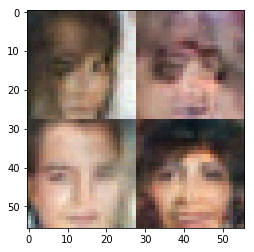

Epoch 5/30... Discriminator Loss: 0.6144... Generator Loss: 1.2734
Epoch 5/30... Discriminator Loss: 2.0382... Generator Loss: 3.9588
Epoch 5/30... Discriminator Loss: 1.9509... Generator Loss: 2.4137
Epoch 5/30... Discriminator Loss: 0.6885... Generator Loss: 1.1218
Epoch 5/30... Discriminator Loss: 2.7642... Generator Loss: 0.1165
Epoch 5/30... Discriminator Loss: 0.7501... Generator Loss: 1.4455
Epoch 5/30... Discriminator Loss: 1.3663... Generator Loss: 0.5093
Epoch 5/30... Discriminator Loss: 0.7285... Generator Loss: 0.9524
Epoch 5/30... Discriminator Loss: 1.4397... Generator Loss: 2.5063
Epoch 5/30... Discriminator Loss: 0.5343... Generator Loss: 1.9519


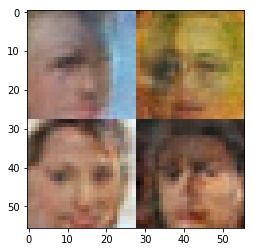

Epoch 5/30... Discriminator Loss: 1.6800... Generator Loss: 1.9955
Epoch 5/30... Discriminator Loss: 1.2073... Generator Loss: 0.5494
Epoch 5/30... Discriminator Loss: 1.5939... Generator Loss: 0.3527
Epoch 5/30... Discriminator Loss: 0.9689... Generator Loss: 0.9470
Epoch 5/30... Discriminator Loss: 1.9992... Generator Loss: 0.2067
Epoch 5/30... Discriminator Loss: 0.6487... Generator Loss: 1.0638
Epoch 5/30... Discriminator Loss: 0.5663... Generator Loss: 1.9716
Epoch 5/30... Discriminator Loss: 0.8844... Generator Loss: 0.9491
Epoch 5/30... Discriminator Loss: 0.2248... Generator Loss: 2.9985
Epoch 5/30... Discriminator Loss: 0.4195... Generator Loss: 1.4928


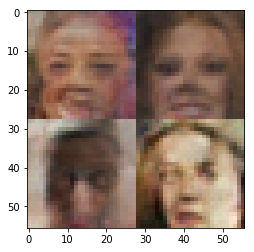

Epoch 5/30... Discriminator Loss: 1.1245... Generator Loss: 1.6177
Epoch 5/30... Discriminator Loss: 1.1188... Generator Loss: 2.0776
Epoch 5/30... Discriminator Loss: 1.2301... Generator Loss: 0.5203
Epoch 5/30... Discriminator Loss: 0.6814... Generator Loss: 4.5419
Epoch 5/30... Discriminator Loss: 0.8192... Generator Loss: 0.8139
Epoch 5/30... Discriminator Loss: 1.4397... Generator Loss: 2.6391
Epoch 5/30... Discriminator Loss: 1.1301... Generator Loss: 0.9483
Epoch 5/30... Discriminator Loss: 1.0933... Generator Loss: 1.4861
Epoch 5/30... Discriminator Loss: 0.9983... Generator Loss: 1.0753
Epoch 5/30... Discriminator Loss: 0.5014... Generator Loss: 1.7992


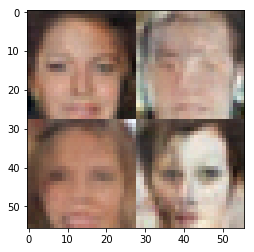

Epoch 5/30... Discriminator Loss: 0.4092... Generator Loss: 4.0204
Epoch 5/30... Discriminator Loss: 0.6121... Generator Loss: 1.8380
Epoch 5/30... Discriminator Loss: 1.2380... Generator Loss: 0.4858
Epoch 5/30... Discriminator Loss: 0.4032... Generator Loss: 1.6360
Epoch 5/30... Discriminator Loss: 0.7675... Generator Loss: 2.8879
Epoch 5/30... Discriminator Loss: 1.0691... Generator Loss: 2.2125
Epoch 5/30... Discriminator Loss: 0.9088... Generator Loss: 1.3029
Epoch 5/30... Discriminator Loss: 0.8731... Generator Loss: 0.9925
Epoch 5/30... Discriminator Loss: 0.9321... Generator Loss: 2.8463
Epoch 5/30... Discriminator Loss: 1.1103... Generator Loss: 0.7772


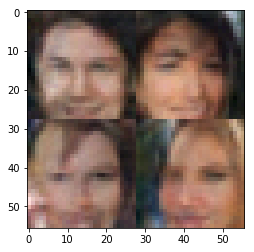

Epoch 5/30... Discriminator Loss: 1.3958... Generator Loss: 0.4513
Epoch 5/30... Discriminator Loss: 0.7783... Generator Loss: 1.0998
Epoch 5/30... Discriminator Loss: 0.6116... Generator Loss: 1.9807
Epoch 5/30... Discriminator Loss: 0.7269... Generator Loss: 1.9124
Epoch 5/30... Discriminator Loss: 2.0810... Generator Loss: 1.4336
Epoch 5/30... Discriminator Loss: 0.6838... Generator Loss: 2.1076
Epoch 5/30... Discriminator Loss: 0.5571... Generator Loss: 2.7575
Epoch 5/30... Discriminator Loss: 1.2635... Generator Loss: 0.5493
Epoch 5/30... Discriminator Loss: 1.7467... Generator Loss: 0.2736
Epoch 5/30... Discriminator Loss: 0.7362... Generator Loss: 1.1786


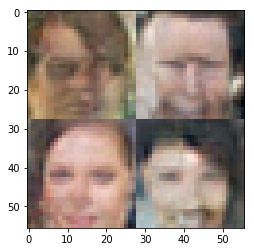

Epoch 5/30... Discriminator Loss: 0.7150... Generator Loss: 1.7676
Epoch 5/30... Discriminator Loss: 0.6551... Generator Loss: 2.6969
Epoch 5/30... Discriminator Loss: 0.8290... Generator Loss: 0.8680
Epoch 5/30... Discriminator Loss: 1.3227... Generator Loss: 0.4411
Epoch 5/30... Discriminator Loss: 1.9997... Generator Loss: 0.2063
Epoch 5/30... Discriminator Loss: 1.3613... Generator Loss: 0.8002
Epoch 5/30... Discriminator Loss: 1.4201... Generator Loss: 0.4391
Epoch 5/30... Discriminator Loss: 1.2233... Generator Loss: 0.6996
Epoch 5/30... Discriminator Loss: 0.6649... Generator Loss: 1.8355
Epoch 5/30... Discriminator Loss: 0.7111... Generator Loss: 0.9914


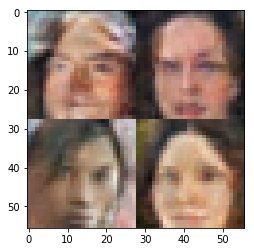

Epoch 5/30... Discriminator Loss: 0.8935... Generator Loss: 0.7518
Epoch 5/30... Discriminator Loss: 1.1951... Generator Loss: 0.6801
Epoch 5/30... Discriminator Loss: 0.9369... Generator Loss: 0.9981
Epoch 5/30... Discriminator Loss: 0.7777... Generator Loss: 1.6999
Epoch 5/30... Discriminator Loss: 1.2962... Generator Loss: 0.4655
Epoch 5/30... Discriminator Loss: 0.6306... Generator Loss: 2.5809
Epoch 5/30... Discriminator Loss: 1.6397... Generator Loss: 0.3010
Epoch 5/30... Discriminator Loss: 0.7821... Generator Loss: 1.1255
Epoch 5/30... Discriminator Loss: 0.9778... Generator Loss: 2.5188
Epoch 5/30... Discriminator Loss: 0.9388... Generator Loss: 1.1818


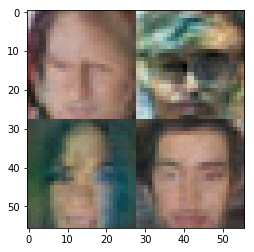

Epoch 5/30... Discriminator Loss: 1.1813... Generator Loss: 0.5685
Epoch 5/30... Discriminator Loss: 0.2532... Generator Loss: 2.9343
Epoch 5/30... Discriminator Loss: 1.0738... Generator Loss: 0.8007
Epoch 5/30... Discriminator Loss: 0.9860... Generator Loss: 0.8302
Epoch 5/30... Discriminator Loss: 1.2976... Generator Loss: 0.4660
Epoch 5/30... Discriminator Loss: 0.3674... Generator Loss: 1.7612
Epoch 5/30... Discriminator Loss: 0.8711... Generator Loss: 0.9282
Epoch 5/30... Discriminator Loss: 0.3593... Generator Loss: 1.8355
Epoch 5/30... Discriminator Loss: 1.0861... Generator Loss: 0.5926
Epoch 5/30... Discriminator Loss: 1.7726... Generator Loss: 2.9047


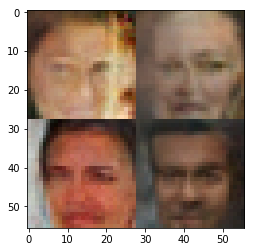

Epoch 5/30... Discriminator Loss: 0.5393... Generator Loss: 1.5028
Epoch 5/30... Discriminator Loss: 0.6155... Generator Loss: 1.3601
Epoch 5/30... Discriminator Loss: 0.3966... Generator Loss: 1.5363
Epoch 5/30... Discriminator Loss: 1.5588... Generator Loss: 0.3573
Epoch 5/30... Discriminator Loss: 1.0534... Generator Loss: 0.9330
Epoch 5/30... Discriminator Loss: 1.0777... Generator Loss: 0.7092
Epoch 5/30... Discriminator Loss: 1.0492... Generator Loss: 0.7948
Epoch 5/30... Discriminator Loss: 1.0795... Generator Loss: 1.4393
Epoch 5/30... Discriminator Loss: 0.9885... Generator Loss: 0.6621
Epoch 5/30... Discriminator Loss: 0.9878... Generator Loss: 0.6735


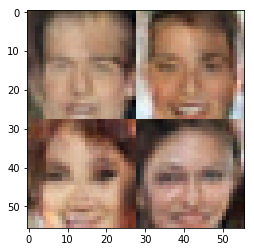

Epoch 5/30... Discriminator Loss: 0.8800... Generator Loss: 1.8908
Epoch 5/30... Discriminator Loss: 1.2201... Generator Loss: 0.6722
Epoch 5/30... Discriminator Loss: 1.2638... Generator Loss: 1.0876
Epoch 5/30... Discriminator Loss: 0.9879... Generator Loss: 1.0971
Epoch 5/30... Discriminator Loss: 0.5267... Generator Loss: 1.6574
Epoch 5/30... Discriminator Loss: 1.0543... Generator Loss: 1.0803
Epoch 5/30... Discriminator Loss: 1.3897... Generator Loss: 1.3059
Epoch 5/30... Discriminator Loss: 1.1412... Generator Loss: 1.5942
Epoch 5/30... Discriminator Loss: 0.9360... Generator Loss: 0.8872
Epoch 5/30... Discriminator Loss: 1.0516... Generator Loss: 1.3401


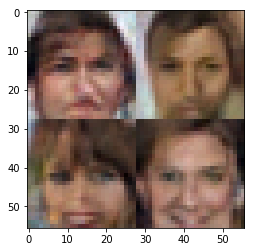

Epoch 5/30... Discriminator Loss: 0.3368... Generator Loss: 2.0136
Epoch 5/30... Discriminator Loss: 1.3217... Generator Loss: 0.4944
Epoch 5/30... Discriminator Loss: 0.9195... Generator Loss: 1.1609
Epoch 5/30... Discriminator Loss: 1.3126... Generator Loss: 0.5020
Epoch 5/30... Discriminator Loss: 1.0281... Generator Loss: 0.8358
Epoch 5/30... Discriminator Loss: 1.4791... Generator Loss: 0.4277
Epoch 5/30... Discriminator Loss: 0.9572... Generator Loss: 0.9766
Epoch 5/30... Discriminator Loss: 0.7045... Generator Loss: 1.0920
Epoch 5/30... Discriminator Loss: 0.9568... Generator Loss: 1.1268
Epoch 5/30... Discriminator Loss: 1.0503... Generator Loss: 0.6220


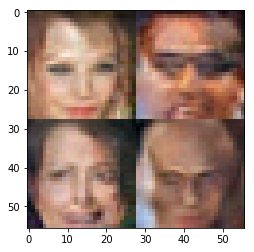

Epoch 5/30... Discriminator Loss: 1.1252... Generator Loss: 1.1570
epoch_i 5
Epoch 6/30... Discriminator Loss: 1.2320... Generator Loss: 0.5677
Epoch 6/30... Discriminator Loss: 1.4145... Generator Loss: 0.4142
Epoch 6/30... Discriminator Loss: 0.5414... Generator Loss: 1.8605
Epoch 6/30... Discriminator Loss: 1.1409... Generator Loss: 0.5762
Epoch 6/30... Discriminator Loss: 0.8418... Generator Loss: 0.9441
Epoch 6/30... Discriminator Loss: 1.0608... Generator Loss: 0.7021
Epoch 6/30... Discriminator Loss: 1.4197... Generator Loss: 0.4088
Epoch 6/30... Discriminator Loss: 0.9965... Generator Loss: 1.3791
Epoch 6/30... Discriminator Loss: 0.5572... Generator Loss: 1.3582


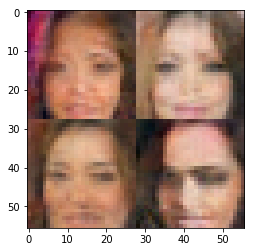

Epoch 6/30... Discriminator Loss: 1.1547... Generator Loss: 0.7990
Epoch 6/30... Discriminator Loss: 0.7607... Generator Loss: 1.0388
Epoch 6/30... Discriminator Loss: 1.4943... Generator Loss: 0.3793
Epoch 6/30... Discriminator Loss: 0.7903... Generator Loss: 1.2866
Epoch 6/30... Discriminator Loss: 0.7802... Generator Loss: 0.8873
Epoch 6/30... Discriminator Loss: 1.4374... Generator Loss: 0.3726
Epoch 6/30... Discriminator Loss: 1.1349... Generator Loss: 1.1868
Epoch 6/30... Discriminator Loss: 1.1551... Generator Loss: 1.3431
Epoch 6/30... Discriminator Loss: 1.0896... Generator Loss: 2.2147
Epoch 6/30... Discriminator Loss: 1.1135... Generator Loss: 0.6038


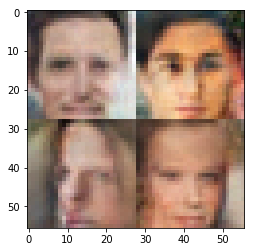

Epoch 6/30... Discriminator Loss: 1.5095... Generator Loss: 0.3902
Epoch 6/30... Discriminator Loss: 1.4655... Generator Loss: 0.3736
Epoch 6/30... Discriminator Loss: 0.8069... Generator Loss: 1.0656
Epoch 6/30... Discriminator Loss: 0.7562... Generator Loss: 1.8865
Epoch 6/30... Discriminator Loss: 0.6075... Generator Loss: 1.5274
Epoch 6/30... Discriminator Loss: 1.0834... Generator Loss: 0.6992
Epoch 6/30... Discriminator Loss: 0.5119... Generator Loss: 1.3299
Epoch 6/30... Discriminator Loss: 0.6842... Generator Loss: 1.0172
Epoch 6/30... Discriminator Loss: 0.9232... Generator Loss: 1.4341
Epoch 6/30... Discriminator Loss: 1.1884... Generator Loss: 0.5957


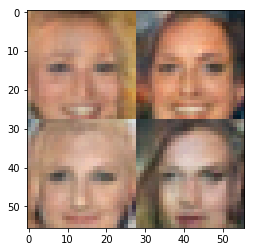

Epoch 6/30... Discriminator Loss: 1.3040... Generator Loss: 0.4374
Epoch 6/30... Discriminator Loss: 0.8173... Generator Loss: 0.8374
Epoch 6/30... Discriminator Loss: 0.9906... Generator Loss: 1.1482
Epoch 6/30... Discriminator Loss: 0.8005... Generator Loss: 1.3231
Epoch 6/30... Discriminator Loss: 1.3390... Generator Loss: 0.4196
Epoch 6/30... Discriminator Loss: 0.8796... Generator Loss: 1.6184
Epoch 6/30... Discriminator Loss: 0.7244... Generator Loss: 1.9549
Epoch 6/30... Discriminator Loss: 1.0466... Generator Loss: 1.9656
Epoch 6/30... Discriminator Loss: 1.1041... Generator Loss: 0.6124
Epoch 6/30... Discriminator Loss: 0.7579... Generator Loss: 1.4945


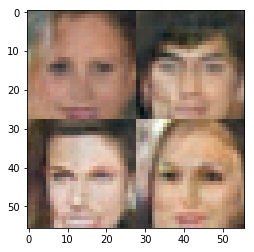

Epoch 6/30... Discriminator Loss: 0.9578... Generator Loss: 2.0817
Epoch 6/30... Discriminator Loss: 1.0331... Generator Loss: 0.7703
Epoch 6/30... Discriminator Loss: 0.9920... Generator Loss: 0.6044
Epoch 6/30... Discriminator Loss: 1.3159... Generator Loss: 0.4867
Epoch 6/30... Discriminator Loss: 1.7282... Generator Loss: 0.2793
Epoch 6/30... Discriminator Loss: 1.1350... Generator Loss: 0.6352
Epoch 6/30... Discriminator Loss: 0.4135... Generator Loss: 1.8268
Epoch 6/30... Discriminator Loss: 0.7425... Generator Loss: 1.7457
Epoch 6/30... Discriminator Loss: 1.0922... Generator Loss: 0.6788
Epoch 6/30... Discriminator Loss: 0.7247... Generator Loss: 1.4807


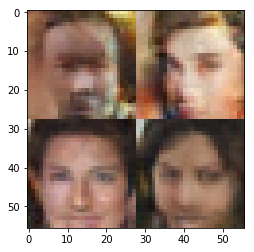

Epoch 6/30... Discriminator Loss: 1.3502... Generator Loss: 0.4773
Epoch 6/30... Discriminator Loss: 1.1946... Generator Loss: 1.2204
Epoch 6/30... Discriminator Loss: 1.1812... Generator Loss: 1.4254
Epoch 6/30... Discriminator Loss: 1.1604... Generator Loss: 0.8090
Epoch 6/30... Discriminator Loss: 1.0442... Generator Loss: 0.8497
Epoch 6/30... Discriminator Loss: 0.7531... Generator Loss: 1.7062
Epoch 6/30... Discriminator Loss: 1.0272... Generator Loss: 0.7792
Epoch 6/30... Discriminator Loss: 0.8571... Generator Loss: 0.9226
Epoch 6/30... Discriminator Loss: 1.0677... Generator Loss: 0.9649
Epoch 6/30... Discriminator Loss: 0.9412... Generator Loss: 0.9063


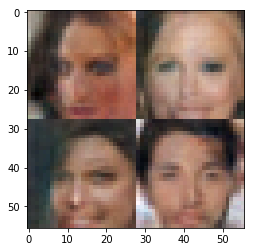

Epoch 6/30... Discriminator Loss: 1.3249... Generator Loss: 2.0862
Epoch 6/30... Discriminator Loss: 0.4639... Generator Loss: 1.5281
Epoch 6/30... Discriminator Loss: 0.8641... Generator Loss: 0.9420
Epoch 6/30... Discriminator Loss: 1.1409... Generator Loss: 1.3309
Epoch 6/30... Discriminator Loss: 1.0500... Generator Loss: 0.7539
Epoch 6/30... Discriminator Loss: 0.7576... Generator Loss: 0.8589
Epoch 6/30... Discriminator Loss: 1.1449... Generator Loss: 1.2878
Epoch 6/30... Discriminator Loss: 1.5483... Generator Loss: 0.3969
Epoch 6/30... Discriminator Loss: 1.4661... Generator Loss: 0.4003
Epoch 6/30... Discriminator Loss: 1.3454... Generator Loss: 0.6029


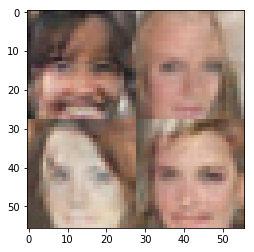

Epoch 6/30... Discriminator Loss: 0.8900... Generator Loss: 1.0910
Epoch 6/30... Discriminator Loss: 0.5356... Generator Loss: 1.2689
Epoch 6/30... Discriminator Loss: 1.3305... Generator Loss: 0.8434
Epoch 6/30... Discriminator Loss: 1.9772... Generator Loss: 3.0186
Epoch 6/30... Discriminator Loss: 1.2706... Generator Loss: 0.4587
Epoch 6/30... Discriminator Loss: 1.0209... Generator Loss: 1.5951
Epoch 6/30... Discriminator Loss: 1.0673... Generator Loss: 1.1175
Epoch 6/30... Discriminator Loss: 0.3184... Generator Loss: 2.8996
Epoch 6/30... Discriminator Loss: 1.0725... Generator Loss: 1.4636
Epoch 6/30... Discriminator Loss: 0.4278... Generator Loss: 1.7187


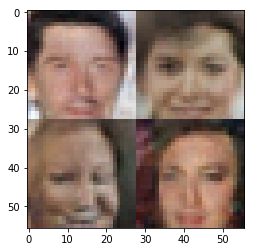

Epoch 6/30... Discriminator Loss: 0.9590... Generator Loss: 0.9476
Epoch 6/30... Discriminator Loss: 0.8731... Generator Loss: 0.8860
Epoch 6/30... Discriminator Loss: 0.8863... Generator Loss: 1.2424
Epoch 6/30... Discriminator Loss: 1.7275... Generator Loss: 0.2869
Epoch 6/30... Discriminator Loss: 1.1562... Generator Loss: 1.2501
Epoch 6/30... Discriminator Loss: 0.8710... Generator Loss: 1.6614
Epoch 6/30... Discriminator Loss: 1.0878... Generator Loss: 1.1960
Epoch 6/30... Discriminator Loss: 1.1816... Generator Loss: 0.7187
Epoch 6/30... Discriminator Loss: 1.4760... Generator Loss: 0.3925
Epoch 6/30... Discriminator Loss: 1.2312... Generator Loss: 0.5297


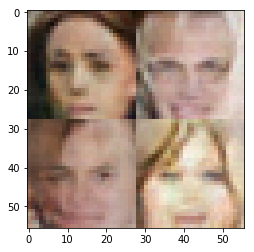

Epoch 6/30... Discriminator Loss: 0.8676... Generator Loss: 0.9496
Epoch 6/30... Discriminator Loss: 0.6560... Generator Loss: 1.3910
Epoch 6/30... Discriminator Loss: 0.9683... Generator Loss: 0.8239
Epoch 6/30... Discriminator Loss: 0.8374... Generator Loss: 1.9380
Epoch 6/30... Discriminator Loss: 0.9971... Generator Loss: 0.7391
Epoch 6/30... Discriminator Loss: 1.0062... Generator Loss: 1.7100
Epoch 6/30... Discriminator Loss: 0.8996... Generator Loss: 0.7433
Epoch 6/30... Discriminator Loss: 0.8887... Generator Loss: 0.8875
Epoch 6/30... Discriminator Loss: 1.0087... Generator Loss: 0.7819
Epoch 6/30... Discriminator Loss: 0.7998... Generator Loss: 1.3093


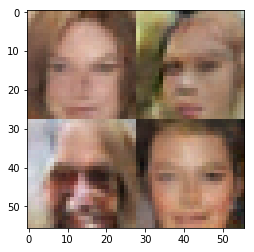

Epoch 6/30... Discriminator Loss: 1.0968... Generator Loss: 0.6127
Epoch 6/30... Discriminator Loss: 1.5960... Generator Loss: 0.4795
Epoch 6/30... Discriminator Loss: 1.0523... Generator Loss: 0.6423
Epoch 6/30... Discriminator Loss: 0.8537... Generator Loss: 0.7940
Epoch 6/30... Discriminator Loss: 2.0790... Generator Loss: 1.8287
Epoch 6/30... Discriminator Loss: 0.9598... Generator Loss: 0.8813
Epoch 6/30... Discriminator Loss: 0.6466... Generator Loss: 1.1068
Epoch 6/30... Discriminator Loss: 4.1084... Generator Loss: 4.1610
Epoch 6/30... Discriminator Loss: 1.1454... Generator Loss: 0.9101
Epoch 6/30... Discriminator Loss: 1.1225... Generator Loss: 0.6259


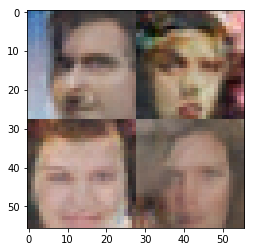

Epoch 6/30... Discriminator Loss: 1.1695... Generator Loss: 0.5474
Epoch 6/30... Discriminator Loss: 1.5623... Generator Loss: 2.6060
Epoch 6/30... Discriminator Loss: 1.0627... Generator Loss: 0.6712
Epoch 6/30... Discriminator Loss: 1.3510... Generator Loss: 0.4290
Epoch 6/30... Discriminator Loss: 1.2175... Generator Loss: 0.5142
Epoch 6/30... Discriminator Loss: 0.8929... Generator Loss: 1.3012
Epoch 6/30... Discriminator Loss: 0.8921... Generator Loss: 1.2261
Epoch 6/30... Discriminator Loss: 1.6307... Generator Loss: 0.2987
Epoch 6/30... Discriminator Loss: 1.7982... Generator Loss: 0.2503
Epoch 6/30... Discriminator Loss: 0.4350... Generator Loss: 2.2106


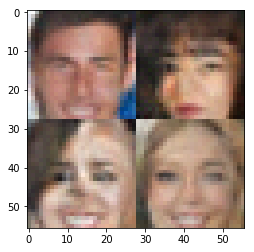

Epoch 6/30... Discriminator Loss: 1.1610... Generator Loss: 2.6091
Epoch 6/30... Discriminator Loss: 1.0487... Generator Loss: 1.2862
Epoch 6/30... Discriminator Loss: 0.7086... Generator Loss: 0.9140
Epoch 6/30... Discriminator Loss: 1.2887... Generator Loss: 1.3927
Epoch 6/30... Discriminator Loss: 0.6437... Generator Loss: 1.3133
Epoch 6/30... Discriminator Loss: 0.9660... Generator Loss: 0.9558
Epoch 6/30... Discriminator Loss: 1.0809... Generator Loss: 1.0827
Epoch 6/30... Discriminator Loss: 0.8188... Generator Loss: 1.5931
Epoch 6/30... Discriminator Loss: 1.4046... Generator Loss: 0.4192
Epoch 6/30... Discriminator Loss: 1.5225... Generator Loss: 1.9435


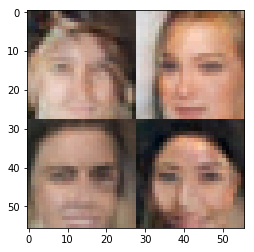

Epoch 6/30... Discriminator Loss: 0.5626... Generator Loss: 1.4701
Epoch 6/30... Discriminator Loss: 0.3823... Generator Loss: 1.5932
Epoch 6/30... Discriminator Loss: 1.0419... Generator Loss: 1.0664
Epoch 6/30... Discriminator Loss: 0.8830... Generator Loss: 1.0528
Epoch 6/30... Discriminator Loss: 1.1543... Generator Loss: 0.6375
Epoch 6/30... Discriminator Loss: 1.9519... Generator Loss: 0.2064
Epoch 6/30... Discriminator Loss: 1.1017... Generator Loss: 0.9291
Epoch 6/30... Discriminator Loss: 1.1431... Generator Loss: 0.8081
Epoch 6/30... Discriminator Loss: 1.2335... Generator Loss: 0.5833
Epoch 6/30... Discriminator Loss: 1.1304... Generator Loss: 0.5691


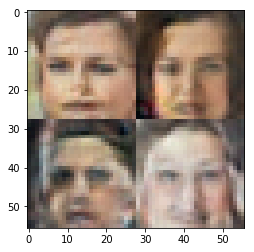

Epoch 6/30... Discriminator Loss: 0.6115... Generator Loss: 1.3701
Epoch 6/30... Discriminator Loss: 1.1259... Generator Loss: 0.6697
Epoch 6/30... Discriminator Loss: 1.4003... Generator Loss: 0.7199
Epoch 6/30... Discriminator Loss: 1.1906... Generator Loss: 0.7417
Epoch 6/30... Discriminator Loss: 1.0379... Generator Loss: 0.7530
Epoch 6/30... Discriminator Loss: 1.1910... Generator Loss: 0.9029
Epoch 6/30... Discriminator Loss: 1.2062... Generator Loss: 0.4971
Epoch 6/30... Discriminator Loss: 0.6721... Generator Loss: 0.9037
Epoch 6/30... Discriminator Loss: 0.8450... Generator Loss: 0.8757
Epoch 6/30... Discriminator Loss: 1.4508... Generator Loss: 0.5485


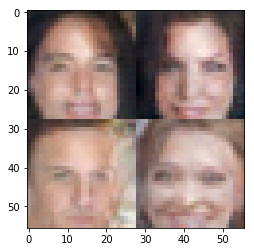

Epoch 6/30... Discriminator Loss: 1.0539... Generator Loss: 0.8775
Epoch 6/30... Discriminator Loss: 0.7909... Generator Loss: 1.0493
Epoch 6/30... Discriminator Loss: 1.1469... Generator Loss: 1.0211
Epoch 6/30... Discriminator Loss: 1.0945... Generator Loss: 0.7700
Epoch 6/30... Discriminator Loss: 0.9871... Generator Loss: 0.8337
Epoch 6/30... Discriminator Loss: 1.0867... Generator Loss: 1.6061
Epoch 6/30... Discriminator Loss: 0.6737... Generator Loss: 1.0855
Epoch 6/30... Discriminator Loss: 1.2905... Generator Loss: 0.4752
Epoch 6/30... Discriminator Loss: 0.8460... Generator Loss: 1.0359
epoch_i 6
Epoch 7/30... Discriminator Loss: 1.1321... Generator Loss: 0.6276


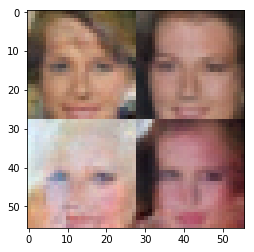

Epoch 7/30... Discriminator Loss: 1.9484... Generator Loss: 0.2390
Epoch 7/30... Discriminator Loss: 1.4062... Generator Loss: 1.0986
Epoch 7/30... Discriminator Loss: 0.4237... Generator Loss: 1.4145
Epoch 7/30... Discriminator Loss: 1.1982... Generator Loss: 1.0398
Epoch 7/30... Discriminator Loss: 1.0928... Generator Loss: 0.8101
Epoch 7/30... Discriminator Loss: 1.4578... Generator Loss: 0.4054
Epoch 7/30... Discriminator Loss: 1.1193... Generator Loss: 0.6883
Epoch 7/30... Discriminator Loss: 1.1886... Generator Loss: 1.1394
Epoch 7/30... Discriminator Loss: 0.5531... Generator Loss: 1.4570
Epoch 7/30... Discriminator Loss: 1.3249... Generator Loss: 0.4206


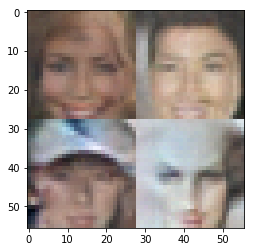

Epoch 7/30... Discriminator Loss: 1.0126... Generator Loss: 1.0420
Epoch 7/30... Discriminator Loss: 0.9571... Generator Loss: 0.7128
Epoch 7/30... Discriminator Loss: 0.4472... Generator Loss: 1.6220
Epoch 7/30... Discriminator Loss: 1.3268... Generator Loss: 2.8346
Epoch 7/30... Discriminator Loss: 0.9438... Generator Loss: 1.0074
Epoch 7/30... Discriminator Loss: 1.1472... Generator Loss: 0.6731
Epoch 7/30... Discriminator Loss: 1.2013... Generator Loss: 0.8428
Epoch 7/30... Discriminator Loss: 1.4472... Generator Loss: 0.5944
Epoch 7/30... Discriminator Loss: 1.0295... Generator Loss: 0.9631
Epoch 7/30... Discriminator Loss: 1.9447... Generator Loss: 2.7958


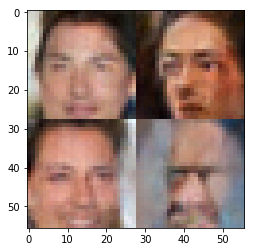

Epoch 7/30... Discriminator Loss: 1.3531... Generator Loss: 1.1331
Epoch 7/30... Discriminator Loss: 1.0752... Generator Loss: 0.9749
Epoch 7/30... Discriminator Loss: 0.8677... Generator Loss: 0.9857
Epoch 7/30... Discriminator Loss: 0.9155... Generator Loss: 0.7772
Epoch 7/30... Discriminator Loss: 1.0251... Generator Loss: 0.8217
Epoch 7/30... Discriminator Loss: 1.0048... Generator Loss: 1.0382
Epoch 7/30... Discriminator Loss: 3.7198... Generator Loss: 3.1348
Epoch 7/30... Discriminator Loss: 1.5078... Generator Loss: 0.4253
Epoch 7/30... Discriminator Loss: 1.3038... Generator Loss: 0.5221
Epoch 7/30... Discriminator Loss: 0.9049... Generator Loss: 1.6305


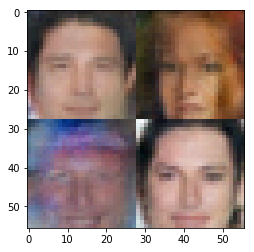

Epoch 7/30... Discriminator Loss: 1.1173... Generator Loss: 0.8159
Epoch 7/30... Discriminator Loss: 1.0769... Generator Loss: 0.8271
Epoch 7/30... Discriminator Loss: 1.0079... Generator Loss: 0.8950
Epoch 7/30... Discriminator Loss: 1.4502... Generator Loss: 0.4522
Epoch 7/30... Discriminator Loss: 1.1722... Generator Loss: 0.8750
Epoch 7/30... Discriminator Loss: 1.2860... Generator Loss: 1.1131
Epoch 7/30... Discriminator Loss: 1.3025... Generator Loss: 0.5618
Epoch 7/30... Discriminator Loss: 0.4351... Generator Loss: 1.9139
Epoch 7/30... Discriminator Loss: 1.1433... Generator Loss: 0.9932
Epoch 7/30... Discriminator Loss: 1.0546... Generator Loss: 0.8922


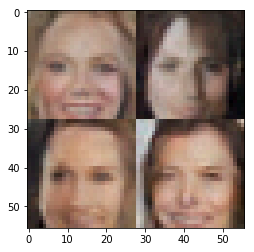

Epoch 7/30... Discriminator Loss: 1.0219... Generator Loss: 0.6952
Epoch 7/30... Discriminator Loss: 1.1323... Generator Loss: 1.3466
Epoch 7/30... Discriminator Loss: 1.1379... Generator Loss: 0.8377
Epoch 7/30... Discriminator Loss: 2.4139... Generator Loss: 0.1325
Epoch 7/30... Discriminator Loss: 1.1676... Generator Loss: 0.6653
Epoch 7/30... Discriminator Loss: 0.5829... Generator Loss: 1.1956
Epoch 7/30... Discriminator Loss: 1.5880... Generator Loss: 0.3781
Epoch 7/30... Discriminator Loss: 0.6063... Generator Loss: 2.2905
Epoch 7/30... Discriminator Loss: 1.9645... Generator Loss: 0.4251
Epoch 7/30... Discriminator Loss: 1.1615... Generator Loss: 0.5521


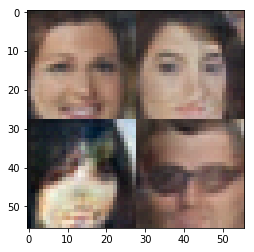

Epoch 7/30... Discriminator Loss: 1.2315... Generator Loss: 0.5988
Epoch 7/30... Discriminator Loss: 0.7885... Generator Loss: 1.9744
Epoch 7/30... Discriminator Loss: 1.3640... Generator Loss: 0.4680
Epoch 7/30... Discriminator Loss: 1.2436... Generator Loss: 0.5579
Epoch 7/30... Discriminator Loss: 1.1428... Generator Loss: 0.5578
Epoch 7/30... Discriminator Loss: 1.1154... Generator Loss: 1.2096
Epoch 7/30... Discriminator Loss: 0.5133... Generator Loss: 1.8628
Epoch 7/30... Discriminator Loss: 1.1512... Generator Loss: 0.7589
Epoch 7/30... Discriminator Loss: 1.1074... Generator Loss: 0.7952
Epoch 7/30... Discriminator Loss: 0.2953... Generator Loss: 1.8607


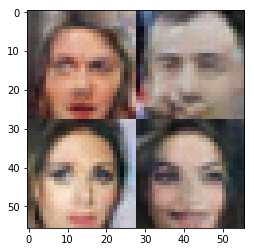

Epoch 7/30... Discriminator Loss: 1.2586... Generator Loss: 1.1734
Epoch 7/30... Discriminator Loss: 1.0606... Generator Loss: 0.6414
Epoch 7/30... Discriminator Loss: 0.8644... Generator Loss: 0.6808
Epoch 7/30... Discriminator Loss: 1.4024... Generator Loss: 0.4219
Epoch 7/30... Discriminator Loss: 0.9384... Generator Loss: 1.0798
Epoch 7/30... Discriminator Loss: 1.1474... Generator Loss: 0.6585
Epoch 7/30... Discriminator Loss: 1.1362... Generator Loss: 0.6569
Epoch 7/30... Discriminator Loss: 0.4836... Generator Loss: 1.5439
Epoch 7/30... Discriminator Loss: 0.4295... Generator Loss: 1.7435
Epoch 7/30... Discriminator Loss: 1.0540... Generator Loss: 0.7144


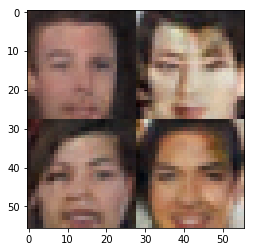

Epoch 7/30... Discriminator Loss: 0.8160... Generator Loss: 1.5565
Epoch 7/30... Discriminator Loss: 1.3093... Generator Loss: 0.7855
Epoch 7/30... Discriminator Loss: 1.2615... Generator Loss: 0.5491
Epoch 7/30... Discriminator Loss: 1.1549... Generator Loss: 1.1686
Epoch 7/30... Discriminator Loss: 1.0586... Generator Loss: 0.7929
Epoch 7/30... Discriminator Loss: 1.0743... Generator Loss: 0.8454
Epoch 7/30... Discriminator Loss: 1.0589... Generator Loss: 0.7784
Epoch 7/30... Discriminator Loss: 1.0644... Generator Loss: 1.2191
Epoch 7/30... Discriminator Loss: 0.5243... Generator Loss: 1.7229
Epoch 7/30... Discriminator Loss: 0.8377... Generator Loss: 1.1411


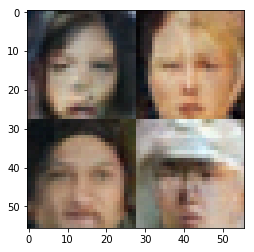

Epoch 7/30... Discriminator Loss: 0.8057... Generator Loss: 1.6263
Epoch 7/30... Discriminator Loss: 1.2310... Generator Loss: 0.6338
Epoch 7/30... Discriminator Loss: 0.6383... Generator Loss: 1.1429
Epoch 7/30... Discriminator Loss: 1.0137... Generator Loss: 0.7794
Epoch 7/30... Discriminator Loss: 1.4959... Generator Loss: 0.8154
Epoch 7/30... Discriminator Loss: 0.9265... Generator Loss: 1.3824
Epoch 7/30... Discriminator Loss: 0.6320... Generator Loss: 1.4046
Epoch 7/30... Discriminator Loss: 1.2491... Generator Loss: 0.9946
Epoch 7/30... Discriminator Loss: 1.0001... Generator Loss: 0.5875
Epoch 7/30... Discriminator Loss: 1.3210... Generator Loss: 0.4792


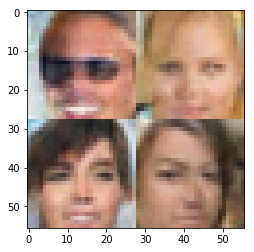

Epoch 7/30... Discriminator Loss: 0.8300... Generator Loss: 1.4351
Epoch 7/30... Discriminator Loss: 1.0428... Generator Loss: 0.7094
Epoch 7/30... Discriminator Loss: 1.1629... Generator Loss: 0.5461
Epoch 7/30... Discriminator Loss: 0.7767... Generator Loss: 1.2061
Epoch 7/30... Discriminator Loss: 1.0087... Generator Loss: 1.3970
Epoch 7/30... Discriminator Loss: 0.7352... Generator Loss: 2.1198
Epoch 7/30... Discriminator Loss: 1.1880... Generator Loss: 0.7405
Epoch 7/30... Discriminator Loss: 0.9452... Generator Loss: 0.8205
Epoch 7/30... Discriminator Loss: 1.3758... Generator Loss: 0.4540
Epoch 7/30... Discriminator Loss: 0.8023... Generator Loss: 1.1671


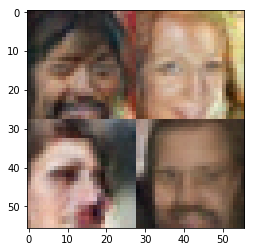

Epoch 7/30... Discriminator Loss: 1.3639... Generator Loss: 0.5211
Epoch 7/30... Discriminator Loss: 0.4217... Generator Loss: 2.8289
Epoch 7/30... Discriminator Loss: 3.1566... Generator Loss: 3.3059
Epoch 7/30... Discriminator Loss: 1.5175... Generator Loss: 0.3673
Epoch 7/30... Discriminator Loss: 1.3562... Generator Loss: 0.5116
Epoch 7/30... Discriminator Loss: 1.0226... Generator Loss: 1.0603
Epoch 7/30... Discriminator Loss: 1.0856... Generator Loss: 0.6842
Epoch 7/30... Discriminator Loss: 0.9801... Generator Loss: 1.0187
Epoch 7/30... Discriminator Loss: 1.1081... Generator Loss: 0.7654
Epoch 7/30... Discriminator Loss: 0.8866... Generator Loss: 1.7082


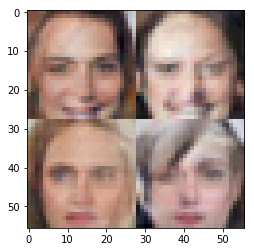

Epoch 7/30... Discriminator Loss: 0.7827... Generator Loss: 1.1895
Epoch 7/30... Discriminator Loss: 0.8807... Generator Loss: 0.7550
Epoch 7/30... Discriminator Loss: 0.4316... Generator Loss: 1.8964
Epoch 7/30... Discriminator Loss: 1.0126... Generator Loss: 0.9956
Epoch 7/30... Discriminator Loss: 1.0403... Generator Loss: 1.1072
Epoch 7/30... Discriminator Loss: 0.7390... Generator Loss: 1.1201
Epoch 7/30... Discriminator Loss: 2.9510... Generator Loss: 3.5645
Epoch 7/30... Discriminator Loss: 1.3009... Generator Loss: 0.7601
Epoch 7/30... Discriminator Loss: 0.7397... Generator Loss: 1.1474
Epoch 7/30... Discriminator Loss: 1.3160... Generator Loss: 0.4520


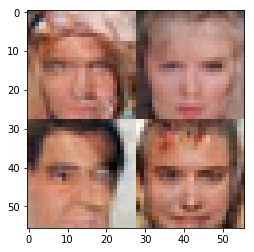

Epoch 7/30... Discriminator Loss: 1.2080... Generator Loss: 0.7156
Epoch 7/30... Discriminator Loss: 1.0904... Generator Loss: 1.2420
Epoch 7/30... Discriminator Loss: 1.1215... Generator Loss: 1.0208
Epoch 7/30... Discriminator Loss: 0.3224... Generator Loss: 2.0905
Epoch 7/30... Discriminator Loss: 0.6411... Generator Loss: 1.3680
Epoch 7/30... Discriminator Loss: 1.0065... Generator Loss: 2.1831
Epoch 7/30... Discriminator Loss: 2.1924... Generator Loss: 1.4404
Epoch 7/30... Discriminator Loss: 1.2246... Generator Loss: 1.1434
Epoch 7/30... Discriminator Loss: 1.1078... Generator Loss: 1.2445
Epoch 7/30... Discriminator Loss: 1.5474... Generator Loss: 0.3649


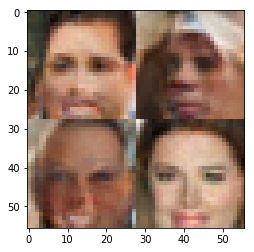

Epoch 7/30... Discriminator Loss: 1.1001... Generator Loss: 0.6175
Epoch 7/30... Discriminator Loss: 1.4763... Generator Loss: 1.3852
Epoch 7/30... Discriminator Loss: 1.5613... Generator Loss: 1.6881
Epoch 7/30... Discriminator Loss: 1.2978... Generator Loss: 2.0214
Epoch 7/30... Discriminator Loss: 1.0166... Generator Loss: 0.8214
Epoch 7/30... Discriminator Loss: 0.9090... Generator Loss: 1.0043
Epoch 7/30... Discriminator Loss: 0.8101... Generator Loss: 1.0944
Epoch 7/30... Discriminator Loss: 1.7637... Generator Loss: 0.2741
Epoch 7/30... Discriminator Loss: 0.3992... Generator Loss: 2.7233
Epoch 7/30... Discriminator Loss: 1.0433... Generator Loss: 1.1208


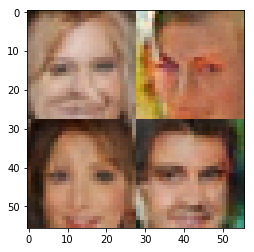

Epoch 7/30... Discriminator Loss: 1.0507... Generator Loss: 0.9810
Epoch 7/30... Discriminator Loss: 0.5696... Generator Loss: 1.2232
Epoch 7/30... Discriminator Loss: 1.0392... Generator Loss: 1.6190
Epoch 7/30... Discriminator Loss: 1.0899... Generator Loss: 2.6195
Epoch 7/30... Discriminator Loss: 0.9542... Generator Loss: 1.1098
Epoch 7/30... Discriminator Loss: 0.2043... Generator Loss: 2.7566
Epoch 7/30... Discriminator Loss: 1.3389... Generator Loss: 0.4452
Epoch 7/30... Discriminator Loss: 0.8036... Generator Loss: 1.0155
Epoch 7/30... Discriminator Loss: 0.6724... Generator Loss: 2.5339
Epoch 7/30... Discriminator Loss: 1.1167... Generator Loss: 1.2951


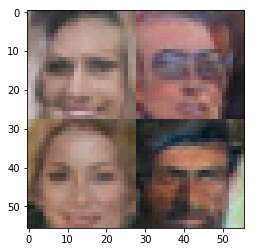

Epoch 7/30... Discriminator Loss: 1.4422... Generator Loss: 1.9581
Epoch 7/30... Discriminator Loss: 1.2040... Generator Loss: 0.8297
Epoch 7/30... Discriminator Loss: 1.0384... Generator Loss: 0.7786
Epoch 7/30... Discriminator Loss: 0.9829... Generator Loss: 1.0274
Epoch 7/30... Discriminator Loss: 1.3294... Generator Loss: 0.6025
Epoch 7/30... Discriminator Loss: 1.4239... Generator Loss: 0.4704
Epoch 7/30... Discriminator Loss: 0.9417... Generator Loss: 0.8446
epoch_i 7
Epoch 8/30... Discriminator Loss: 1.2578... Generator Loss: 0.5990
Epoch 8/30... Discriminator Loss: 0.3281... Generator Loss: 2.9843
Epoch 8/30... Discriminator Loss: 0.9854... Generator Loss: 0.6813


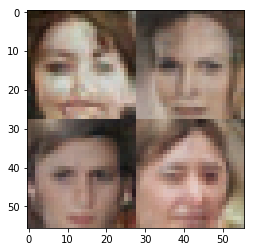

Epoch 8/30... Discriminator Loss: 1.7208... Generator Loss: 1.0494
Epoch 8/30... Discriminator Loss: 1.1059... Generator Loss: 0.7468
Epoch 8/30... Discriminator Loss: 1.0671... Generator Loss: 0.8663
Epoch 8/30... Discriminator Loss: 1.2014... Generator Loss: 0.6966
Epoch 8/30... Discriminator Loss: 1.6046... Generator Loss: 0.3482
Epoch 8/30... Discriminator Loss: 1.0617... Generator Loss: 1.1035
Epoch 8/30... Discriminator Loss: 0.8788... Generator Loss: 1.0774
Epoch 8/30... Discriminator Loss: 1.2193... Generator Loss: 0.4531
Epoch 8/30... Discriminator Loss: 0.6390... Generator Loss: 3.5709
Epoch 8/30... Discriminator Loss: 3.0226... Generator Loss: 2.9325


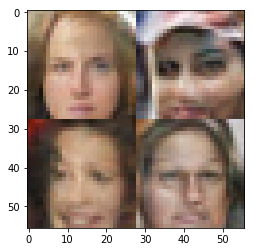

Epoch 8/30... Discriminator Loss: 1.2543... Generator Loss: 0.9448
Epoch 8/30... Discriminator Loss: 1.3945... Generator Loss: 0.5000
Epoch 8/30... Discriminator Loss: 0.7057... Generator Loss: 1.6689
Epoch 8/30... Discriminator Loss: 1.0816... Generator Loss: 0.8831
Epoch 8/30... Discriminator Loss: 1.1056... Generator Loss: 0.7659
Epoch 8/30... Discriminator Loss: 1.2881... Generator Loss: 0.4605
Epoch 8/30... Discriminator Loss: 1.2122... Generator Loss: 0.6973
Epoch 8/30... Discriminator Loss: 1.1087... Generator Loss: 1.1821
Epoch 8/30... Discriminator Loss: 0.7078... Generator Loss: 1.6185
Epoch 8/30... Discriminator Loss: 1.4192... Generator Loss: 0.4500


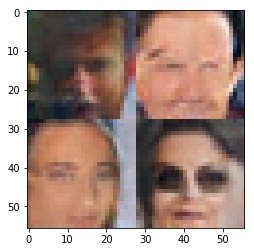

Epoch 8/30... Discriminator Loss: 0.8134... Generator Loss: 1.0382
Epoch 8/30... Discriminator Loss: 1.3607... Generator Loss: 0.6673
Epoch 8/30... Discriminator Loss: 0.5285... Generator Loss: 3.4751
Epoch 8/30... Discriminator Loss: 0.9712... Generator Loss: 0.7372
Epoch 8/30... Discriminator Loss: 1.4595... Generator Loss: 0.3682
Epoch 8/30... Discriminator Loss: 3.1748... Generator Loss: 4.2623
Epoch 8/30... Discriminator Loss: 1.5336... Generator Loss: 0.7373
Epoch 8/30... Discriminator Loss: 1.0173... Generator Loss: 1.2527
Epoch 8/30... Discriminator Loss: 1.2827... Generator Loss: 0.5466
Epoch 8/30... Discriminator Loss: 1.1974... Generator Loss: 0.5834


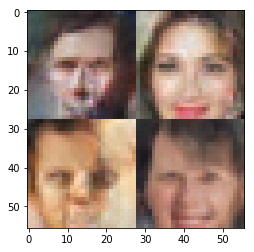

Epoch 8/30... Discriminator Loss: 0.9189... Generator Loss: 1.2170
Epoch 8/30... Discriminator Loss: 1.2745... Generator Loss: 0.5047
Epoch 8/30... Discriminator Loss: 1.2022... Generator Loss: 0.6329
Epoch 8/30... Discriminator Loss: 1.0846... Generator Loss: 0.9275
Epoch 8/30... Discriminator Loss: 1.4840... Generator Loss: 0.3334
Epoch 8/30... Discriminator Loss: 1.7583... Generator Loss: 2.5773
Epoch 8/30... Discriminator Loss: 1.0278... Generator Loss: 1.4224
Epoch 8/30... Discriminator Loss: 0.9742... Generator Loss: 0.6890
Epoch 8/30... Discriminator Loss: 0.9876... Generator Loss: 0.6150
Epoch 8/30... Discriminator Loss: 1.0004... Generator Loss: 1.1232


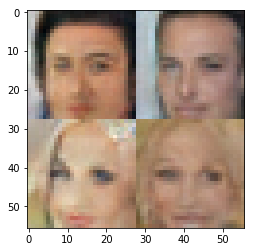

Epoch 8/30... Discriminator Loss: 0.7693... Generator Loss: 0.8338
Epoch 8/30... Discriminator Loss: 1.3448... Generator Loss: 2.0305
Epoch 8/30... Discriminator Loss: 0.5525... Generator Loss: 1.6182
Epoch 8/30... Discriminator Loss: 1.7152... Generator Loss: 0.8643
Epoch 8/30... Discriminator Loss: 1.3148... Generator Loss: 0.6482
Epoch 8/30... Discriminator Loss: 0.4631... Generator Loss: 1.2983
Epoch 8/30... Discriminator Loss: 1.0391... Generator Loss: 0.9931
Epoch 8/30... Discriminator Loss: 1.1135... Generator Loss: 0.6900
Epoch 8/30... Discriminator Loss: 0.5539... Generator Loss: 1.2693
Epoch 8/30... Discriminator Loss: 0.9153... Generator Loss: 2.0856


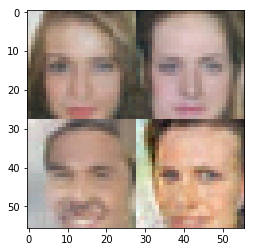

Epoch 8/30... Discriminator Loss: 1.3734... Generator Loss: 1.2188
Epoch 8/30... Discriminator Loss: 0.9009... Generator Loss: 1.1842
Epoch 8/30... Discriminator Loss: 1.4438... Generator Loss: 0.4205
Epoch 8/30... Discriminator Loss: 1.2919... Generator Loss: 0.5308
Epoch 8/30... Discriminator Loss: 1.1111... Generator Loss: 0.8150
Epoch 8/30... Discriminator Loss: 0.5910... Generator Loss: 1.2152
Epoch 8/30... Discriminator Loss: 0.7837... Generator Loss: 2.4269
Epoch 8/30... Discriminator Loss: 0.7336... Generator Loss: 1.7552
Epoch 8/30... Discriminator Loss: 1.2585... Generator Loss: 0.5547
Epoch 8/30... Discriminator Loss: 1.0811... Generator Loss: 0.7939


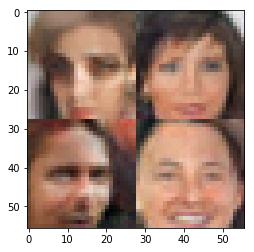

Epoch 8/30... Discriminator Loss: 0.6839... Generator Loss: 1.5522
Epoch 8/30... Discriminator Loss: 0.7214... Generator Loss: 1.7743
Epoch 8/30... Discriminator Loss: 1.3125... Generator Loss: 0.4275
Epoch 8/30... Discriminator Loss: 1.1248... Generator Loss: 1.0101
Epoch 8/30... Discriminator Loss: 1.7459... Generator Loss: 0.2620
Epoch 8/30... Discriminator Loss: 0.9429... Generator Loss: 1.5362
Epoch 8/30... Discriminator Loss: 0.7841... Generator Loss: 0.8269
Epoch 8/30... Discriminator Loss: 0.7305... Generator Loss: 1.8512
Epoch 8/30... Discriminator Loss: 1.5396... Generator Loss: 1.5485
Epoch 8/30... Discriminator Loss: 1.4478... Generator Loss: 0.3889


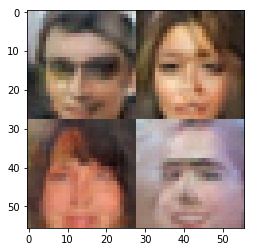

Epoch 8/30... Discriminator Loss: 0.8070... Generator Loss: 2.5092
Epoch 8/30... Discriminator Loss: 0.8995... Generator Loss: 1.3873
Epoch 8/30... Discriminator Loss: 0.9634... Generator Loss: 0.6624
Epoch 8/30... Discriminator Loss: 0.7776... Generator Loss: 0.8583
Epoch 8/30... Discriminator Loss: 1.2209... Generator Loss: 0.4955
Epoch 8/30... Discriminator Loss: 1.0385... Generator Loss: 3.2577
Epoch 8/30... Discriminator Loss: 1.5628... Generator Loss: 0.3303
Epoch 8/30... Discriminator Loss: 1.1214... Generator Loss: 1.0477
Epoch 8/30... Discriminator Loss: 1.1981... Generator Loss: 1.1248
Epoch 8/30... Discriminator Loss: 1.3002... Generator Loss: 0.5666


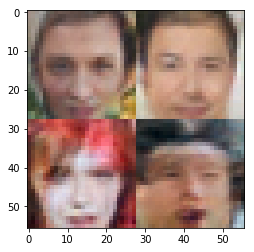

Epoch 8/30... Discriminator Loss: 1.0876... Generator Loss: 0.7050
Epoch 8/30... Discriminator Loss: 1.2353... Generator Loss: 1.0066
Epoch 8/30... Discriminator Loss: 1.3882... Generator Loss: 0.4341
Epoch 8/30... Discriminator Loss: 1.0464... Generator Loss: 1.1778
Epoch 8/30... Discriminator Loss: 1.0529... Generator Loss: 0.9204
Epoch 8/30... Discriminator Loss: 0.6846... Generator Loss: 0.9331
Epoch 8/30... Discriminator Loss: 1.5979... Generator Loss: 0.4381
Epoch 8/30... Discriminator Loss: 1.3343... Generator Loss: 0.8551
Epoch 8/30... Discriminator Loss: 1.3444... Generator Loss: 0.5612
Epoch 8/30... Discriminator Loss: 1.3249... Generator Loss: 0.5491


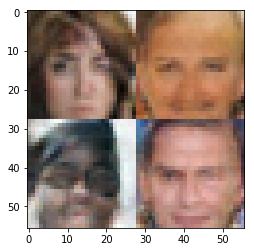

Epoch 8/30... Discriminator Loss: 1.1790... Generator Loss: 0.7242
Epoch 8/30... Discriminator Loss: 1.1049... Generator Loss: 0.9014
Epoch 8/30... Discriminator Loss: 1.1084... Generator Loss: 0.7336
Epoch 8/30... Discriminator Loss: 1.1545... Generator Loss: 1.1893
Epoch 8/30... Discriminator Loss: 1.0723... Generator Loss: 0.9364
Epoch 8/30... Discriminator Loss: 1.1748... Generator Loss: 0.5889
Epoch 8/30... Discriminator Loss: 1.1143... Generator Loss: 0.5591
Epoch 8/30... Discriminator Loss: 1.1553... Generator Loss: 1.1494
Epoch 8/30... Discriminator Loss: 1.3816... Generator Loss: 0.8715
Epoch 8/30... Discriminator Loss: 1.7012... Generator Loss: 0.2980


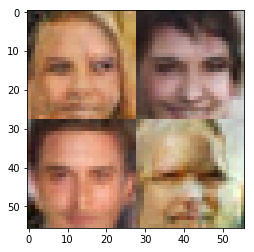

Epoch 8/30... Discriminator Loss: 1.1319... Generator Loss: 0.8860
Epoch 8/30... Discriminator Loss: 1.1167... Generator Loss: 0.9528
Epoch 8/30... Discriminator Loss: 1.2702... Generator Loss: 0.7030
Epoch 8/30... Discriminator Loss: 1.7376... Generator Loss: 1.6867
Epoch 8/30... Discriminator Loss: 1.3811... Generator Loss: 0.4371
Epoch 8/30... Discriminator Loss: 1.1584... Generator Loss: 0.7192
Epoch 8/30... Discriminator Loss: 1.1108... Generator Loss: 1.3361
Epoch 8/30... Discriminator Loss: 1.1567... Generator Loss: 1.3898
Epoch 8/30... Discriminator Loss: 1.3697... Generator Loss: 1.2973
Epoch 8/30... Discriminator Loss: 0.8325... Generator Loss: 1.4299


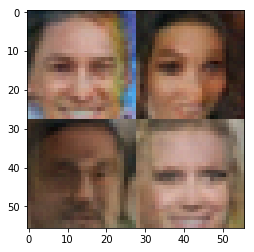

Epoch 8/30... Discriminator Loss: 0.9910... Generator Loss: 1.0274
Epoch 8/30... Discriminator Loss: 0.7105... Generator Loss: 1.1451
Epoch 8/30... Discriminator Loss: 0.4256... Generator Loss: 1.7400
Epoch 8/30... Discriminator Loss: 1.1186... Generator Loss: 0.6852
Epoch 8/30... Discriminator Loss: 0.9397... Generator Loss: 0.6356
Epoch 8/30... Discriminator Loss: 0.6860... Generator Loss: 0.9818
Epoch 8/30... Discriminator Loss: 1.1379... Generator Loss: 0.5994
Epoch 8/30... Discriminator Loss: 0.5947... Generator Loss: 1.6796
Epoch 8/30... Discriminator Loss: 1.5282... Generator Loss: 0.3851
Epoch 8/30... Discriminator Loss: 1.0003... Generator Loss: 0.6572


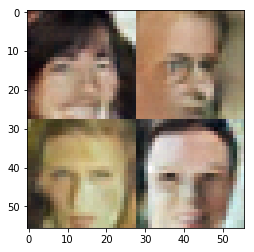

Epoch 8/30... Discriminator Loss: 1.1056... Generator Loss: 0.8337
Epoch 8/30... Discriminator Loss: 0.7454... Generator Loss: 1.0947
Epoch 8/30... Discriminator Loss: 0.9600... Generator Loss: 0.6183
Epoch 8/30... Discriminator Loss: 1.6700... Generator Loss: 0.7763
Epoch 8/30... Discriminator Loss: 0.5067... Generator Loss: 1.6363
Epoch 8/30... Discriminator Loss: 1.0406... Generator Loss: 0.5915
Epoch 8/30... Discriminator Loss: 2.0565... Generator Loss: 0.1938
Epoch 8/30... Discriminator Loss: 1.1066... Generator Loss: 0.8517
Epoch 8/30... Discriminator Loss: 1.1342... Generator Loss: 0.7281
Epoch 8/30... Discriminator Loss: 1.0827... Generator Loss: 0.7287


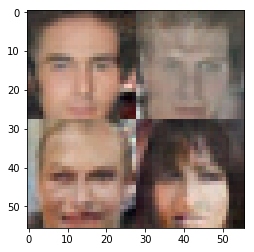

Epoch 8/30... Discriminator Loss: 1.2728... Generator Loss: 0.5724
Epoch 8/30... Discriminator Loss: 1.6214... Generator Loss: 0.3599
Epoch 8/30... Discriminator Loss: 0.8684... Generator Loss: 0.8473
Epoch 8/30... Discriminator Loss: 1.3467... Generator Loss: 0.7112
Epoch 8/30... Discriminator Loss: 1.2361... Generator Loss: 0.5779
Epoch 8/30... Discriminator Loss: 1.1919... Generator Loss: 0.6529
Epoch 8/30... Discriminator Loss: 1.1760... Generator Loss: 0.8600
Epoch 8/30... Discriminator Loss: 1.0487... Generator Loss: 1.0913
Epoch 8/30... Discriminator Loss: 0.8413... Generator Loss: 0.9732
Epoch 8/30... Discriminator Loss: 1.7842... Generator Loss: 0.2804


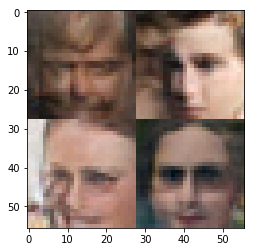

Epoch 8/30... Discriminator Loss: 1.1959... Generator Loss: 0.9016
Epoch 8/30... Discriminator Loss: 1.1831... Generator Loss: 0.9019
Epoch 8/30... Discriminator Loss: 1.2720... Generator Loss: 0.5227
Epoch 8/30... Discriminator Loss: 1.0751... Generator Loss: 0.7075
Epoch 8/30... Discriminator Loss: 1.0683... Generator Loss: 0.7113
Epoch 8/30... Discriminator Loss: 0.8735... Generator Loss: 0.7820
Epoch 8/30... Discriminator Loss: 1.4706... Generator Loss: 0.4321
Epoch 8/30... Discriminator Loss: 1.2388... Generator Loss: 0.8730
Epoch 8/30... Discriminator Loss: 0.9811... Generator Loss: 1.1806
Epoch 8/30... Discriminator Loss: 1.2652... Generator Loss: 0.6683


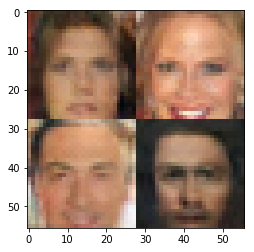

Epoch 8/30... Discriminator Loss: 1.1402... Generator Loss: 0.6620
Epoch 8/30... Discriminator Loss: 1.2981... Generator Loss: 0.5627
Epoch 8/30... Discriminator Loss: 1.7443... Generator Loss: 0.2690
Epoch 8/30... Discriminator Loss: 0.9717... Generator Loss: 0.9975
Epoch 8/30... Discriminator Loss: 1.0960... Generator Loss: 1.1573
epoch_i 8
Epoch 9/30... Discriminator Loss: 1.1001... Generator Loss: 1.0777
Epoch 9/30... Discriminator Loss: 0.7223... Generator Loss: 1.3055
Epoch 9/30... Discriminator Loss: 1.5642... Generator Loss: 0.5639
Epoch 9/30... Discriminator Loss: 1.0901... Generator Loss: 1.0700
Epoch 9/30... Discriminator Loss: 0.8708... Generator Loss: 0.9719


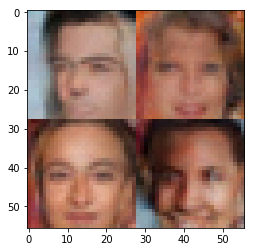

Epoch 9/30... Discriminator Loss: 1.1454... Generator Loss: 0.6937
Epoch 9/30... Discriminator Loss: 0.9075... Generator Loss: 0.8933
Epoch 9/30... Discriminator Loss: 1.4600... Generator Loss: 0.4750
Epoch 9/30... Discriminator Loss: 1.1744... Generator Loss: 0.5850
Epoch 9/30... Discriminator Loss: 1.0240... Generator Loss: 0.6054
Epoch 9/30... Discriminator Loss: 0.4403... Generator Loss: 1.4670
Epoch 9/30... Discriminator Loss: 1.0052... Generator Loss: 0.7280
Epoch 9/30... Discriminator Loss: 0.4759... Generator Loss: 1.6337
Epoch 9/30... Discriminator Loss: 1.3356... Generator Loss: 0.5781
Epoch 9/30... Discriminator Loss: 0.5147... Generator Loss: 1.8617


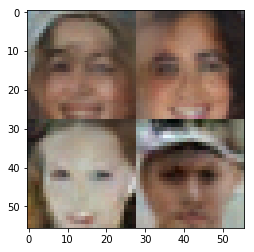

Epoch 9/30... Discriminator Loss: 1.2753... Generator Loss: 0.7028
Epoch 9/30... Discriminator Loss: 1.3897... Generator Loss: 1.1788
Epoch 9/30... Discriminator Loss: 0.4428... Generator Loss: 1.4009
Epoch 9/30... Discriminator Loss: 0.5882... Generator Loss: 1.4104
Epoch 9/30... Discriminator Loss: 1.3645... Generator Loss: 0.4468
Epoch 9/30... Discriminator Loss: 0.7536... Generator Loss: 0.8826
Epoch 9/30... Discriminator Loss: 1.2090... Generator Loss: 0.5192
Epoch 9/30... Discriminator Loss: 1.0408... Generator Loss: 0.6201
Epoch 9/30... Discriminator Loss: 1.9411... Generator Loss: 0.3766
Epoch 9/30... Discriminator Loss: 1.2322... Generator Loss: 0.7815


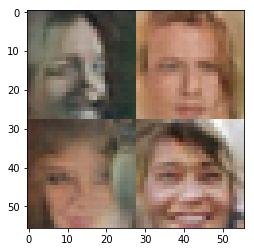

Epoch 9/30... Discriminator Loss: 1.0670... Generator Loss: 0.7908
Epoch 9/30... Discriminator Loss: 1.0952... Generator Loss: 0.7757
Epoch 9/30... Discriminator Loss: 1.1516... Generator Loss: 1.1201
Epoch 9/30... Discriminator Loss: 1.1524... Generator Loss: 0.9357
Epoch 9/30... Discriminator Loss: 1.0187... Generator Loss: 1.0533
Epoch 9/30... Discriminator Loss: 1.2292... Generator Loss: 0.6196
Epoch 9/30... Discriminator Loss: 0.8508... Generator Loss: 0.7536
Epoch 9/30... Discriminator Loss: 2.0992... Generator Loss: 0.3536
Epoch 9/30... Discriminator Loss: 1.0900... Generator Loss: 0.7639
Epoch 9/30... Discriminator Loss: 1.1922... Generator Loss: 0.6492


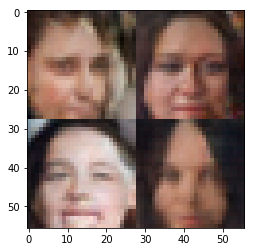

Epoch 9/30... Discriminator Loss: 1.3161... Generator Loss: 0.6987
Epoch 9/30... Discriminator Loss: 1.1690... Generator Loss: 0.8684
Epoch 9/30... Discriminator Loss: 0.9438... Generator Loss: 0.9390
Epoch 9/30... Discriminator Loss: 1.0070... Generator Loss: 0.8341
Epoch 9/30... Discriminator Loss: 0.7113... Generator Loss: 1.3120
Epoch 9/30... Discriminator Loss: 1.0709... Generator Loss: 0.6635
Epoch 9/30... Discriminator Loss: 0.3836... Generator Loss: 1.5317
Epoch 9/30... Discriminator Loss: 1.3352... Generator Loss: 0.6653
Epoch 9/30... Discriminator Loss: 1.2206... Generator Loss: 0.5288
Epoch 9/30... Discriminator Loss: 0.5610... Generator Loss: 1.8013


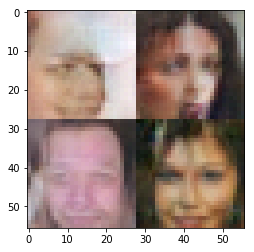

Epoch 9/30... Discriminator Loss: 1.1204... Generator Loss: 0.5846
Epoch 9/30... Discriminator Loss: 0.7858... Generator Loss: 0.9464
Epoch 9/30... Discriminator Loss: 1.5689... Generator Loss: 0.3121
Epoch 9/30... Discriminator Loss: 0.7741... Generator Loss: 1.2908
Epoch 9/30... Discriminator Loss: 1.2219... Generator Loss: 2.9536
Epoch 9/30... Discriminator Loss: 1.1990... Generator Loss: 0.9836
Epoch 9/30... Discriminator Loss: 1.1625... Generator Loss: 0.8902
Epoch 9/30... Discriminator Loss: 1.0241... Generator Loss: 0.7969
Epoch 9/30... Discriminator Loss: 0.7175... Generator Loss: 1.0634
Epoch 9/30... Discriminator Loss: 0.5474... Generator Loss: 1.5524


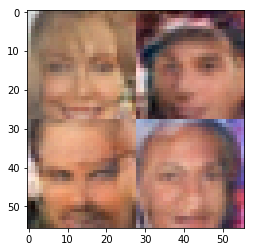

Epoch 9/30... Discriminator Loss: 1.7185... Generator Loss: 0.2959
Epoch 9/30... Discriminator Loss: 1.1317... Generator Loss: 0.7720
Epoch 9/30... Discriminator Loss: 1.2155... Generator Loss: 0.7803
Epoch 9/30... Discriminator Loss: 1.1713... Generator Loss: 0.7206
Epoch 9/30... Discriminator Loss: 0.9907... Generator Loss: 1.5439
Epoch 9/30... Discriminator Loss: 1.2226... Generator Loss: 0.7419
Epoch 9/30... Discriminator Loss: 1.2844... Generator Loss: 0.7068
Epoch 9/30... Discriminator Loss: 1.0703... Generator Loss: 0.8826
Epoch 9/30... Discriminator Loss: 1.2013... Generator Loss: 0.7448
Epoch 9/30... Discriminator Loss: 0.6184... Generator Loss: 1.1865


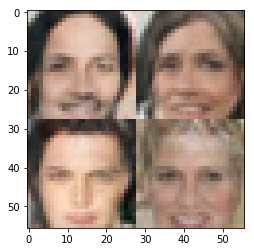

Epoch 9/30... Discriminator Loss: 1.1431... Generator Loss: 1.0431
Epoch 9/30... Discriminator Loss: 0.7431... Generator Loss: 1.2186
Epoch 9/30... Discriminator Loss: 0.7365... Generator Loss: 0.9930
Epoch 9/30... Discriminator Loss: 0.2027... Generator Loss: 2.0520
Epoch 9/30... Discriminator Loss: 1.1039... Generator Loss: 1.3121
Epoch 9/30... Discriminator Loss: 1.1845... Generator Loss: 0.7624
Epoch 9/30... Discriminator Loss: 0.9682... Generator Loss: 0.8616
Epoch 9/30... Discriminator Loss: 0.9879... Generator Loss: 1.4024
Epoch 9/30... Discriminator Loss: 1.3220... Generator Loss: 0.8804
Epoch 9/30... Discriminator Loss: 1.9368... Generator Loss: 0.2412


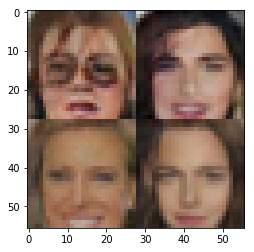

Epoch 9/30... Discriminator Loss: 1.2037... Generator Loss: 1.2315
Epoch 9/30... Discriminator Loss: 1.1901... Generator Loss: 0.9539
Epoch 9/30... Discriminator Loss: 1.2807... Generator Loss: 0.6880
Epoch 9/30... Discriminator Loss: 1.4446... Generator Loss: 0.4724
Epoch 9/30... Discriminator Loss: 1.4103... Generator Loss: 0.4251
Epoch 9/30... Discriminator Loss: 0.4220... Generator Loss: 1.6444
Epoch 9/30... Discriminator Loss: 0.8300... Generator Loss: 1.0615
Epoch 9/30... Discriminator Loss: 1.4286... Generator Loss: 1.8221
Epoch 9/30... Discriminator Loss: 0.7521... Generator Loss: 2.0598
Epoch 9/30... Discriminator Loss: 1.5019... Generator Loss: 0.3664


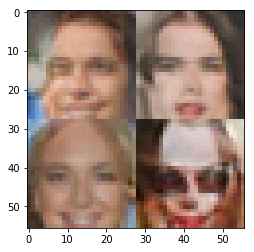

Epoch 9/30... Discriminator Loss: 1.7185... Generator Loss: 0.2792
Epoch 9/30... Discriminator Loss: 0.7932... Generator Loss: 0.8301
Epoch 9/30... Discriminator Loss: 0.9733... Generator Loss: 0.6245
Epoch 9/30... Discriminator Loss: 1.0761... Generator Loss: 0.7439
Epoch 9/30... Discriminator Loss: 1.7440... Generator Loss: 0.3112
Epoch 9/30... Discriminator Loss: 0.8426... Generator Loss: 1.3333
Epoch 9/30... Discriminator Loss: 0.5151... Generator Loss: 1.1077
Epoch 9/30... Discriminator Loss: 0.8739... Generator Loss: 1.2675
Epoch 9/30... Discriminator Loss: 1.0968... Generator Loss: 0.5833
Epoch 9/30... Discriminator Loss: 2.0648... Generator Loss: 0.2294


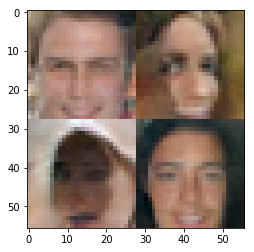

Epoch 9/30... Discriminator Loss: 1.4045... Generator Loss: 0.4708
Epoch 9/30... Discriminator Loss: 1.2053... Generator Loss: 0.5070
Epoch 9/30... Discriminator Loss: 1.1339... Generator Loss: 1.0394
Epoch 9/30... Discriminator Loss: 1.4461... Generator Loss: 0.4184
Epoch 9/30... Discriminator Loss: 0.6538... Generator Loss: 1.3370
Epoch 9/30... Discriminator Loss: 0.8241... Generator Loss: 1.0088
Epoch 9/30... Discriminator Loss: 1.3114... Generator Loss: 0.4489
Epoch 9/30... Discriminator Loss: 0.9163... Generator Loss: 1.3240
Epoch 9/30... Discriminator Loss: 0.3687... Generator Loss: 1.6280
Epoch 9/30... Discriminator Loss: 0.6217... Generator Loss: 1.0056


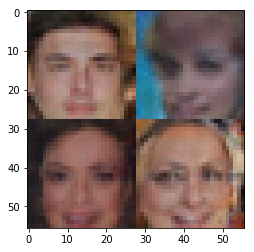

Epoch 9/30... Discriminator Loss: 1.2196... Generator Loss: 0.6489
Epoch 9/30... Discriminator Loss: 1.1808... Generator Loss: 0.6555
Epoch 9/30... Discriminator Loss: 1.1040... Generator Loss: 0.7988
Epoch 9/30... Discriminator Loss: 0.9557... Generator Loss: 0.8762
Epoch 9/30... Discriminator Loss: 1.1296... Generator Loss: 1.3863
Epoch 9/30... Discriminator Loss: 1.0121... Generator Loss: 0.8332
Epoch 9/30... Discriminator Loss: 1.2583... Generator Loss: 0.4688
Epoch 9/30... Discriminator Loss: 0.9234... Generator Loss: 1.1932
Epoch 9/30... Discriminator Loss: 1.1894... Generator Loss: 0.6182
Epoch 9/30... Discriminator Loss: 0.2224... Generator Loss: 2.4870


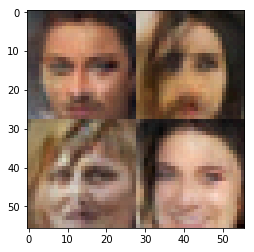

Epoch 9/30... Discriminator Loss: 1.4904... Generator Loss: 0.4245
Epoch 9/30... Discriminator Loss: 0.9848... Generator Loss: 1.0746
Epoch 9/30... Discriminator Loss: 1.3616... Generator Loss: 0.4517
Epoch 9/30... Discriminator Loss: 1.1184... Generator Loss: 0.8444
Epoch 9/30... Discriminator Loss: 0.9909... Generator Loss: 0.9857
Epoch 9/30... Discriminator Loss: 1.2648... Generator Loss: 0.7076
Epoch 9/30... Discriminator Loss: 1.2435... Generator Loss: 1.0660
Epoch 9/30... Discriminator Loss: 1.3230... Generator Loss: 0.9301
Epoch 9/30... Discriminator Loss: 1.2412... Generator Loss: 0.6000
Epoch 9/30... Discriminator Loss: 0.9709... Generator Loss: 0.9158


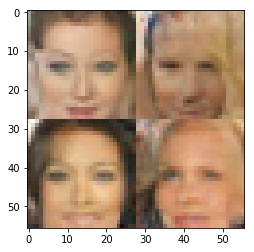

Epoch 9/30... Discriminator Loss: 0.9885... Generator Loss: 0.8173
Epoch 9/30... Discriminator Loss: 1.1022... Generator Loss: 0.6768
Epoch 9/30... Discriminator Loss: 0.4629... Generator Loss: 1.4494
Epoch 9/30... Discriminator Loss: 1.3114... Generator Loss: 0.5103
Epoch 9/30... Discriminator Loss: 0.7930... Generator Loss: 0.9804
Epoch 9/30... Discriminator Loss: 0.9826... Generator Loss: 1.2853
Epoch 9/30... Discriminator Loss: 0.8713... Generator Loss: 1.4251
Epoch 9/30... Discriminator Loss: 0.8413... Generator Loss: 0.7807
Epoch 9/30... Discriminator Loss: 0.6502... Generator Loss: 0.9344
Epoch 9/30... Discriminator Loss: 1.4632... Generator Loss: 0.5072


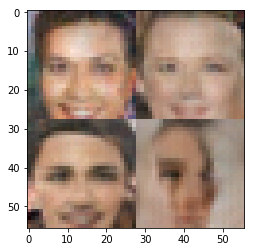

Epoch 9/30... Discriminator Loss: 0.6358... Generator Loss: 1.0405
Epoch 9/30... Discriminator Loss: 1.2867... Generator Loss: 0.7470
Epoch 9/30... Discriminator Loss: 1.1280... Generator Loss: 0.7892
Epoch 9/30... Discriminator Loss: 1.3455... Generator Loss: 0.9959
Epoch 9/30... Discriminator Loss: 1.0982... Generator Loss: 0.7708
Epoch 9/30... Discriminator Loss: 1.2538... Generator Loss: 0.5697
Epoch 9/30... Discriminator Loss: 1.5272... Generator Loss: 0.3632
Epoch 9/30... Discriminator Loss: 1.8092... Generator Loss: 1.4707
Epoch 9/30... Discriminator Loss: 0.6451... Generator Loss: 1.0736
Epoch 9/30... Discriminator Loss: 0.9458... Generator Loss: 1.5536


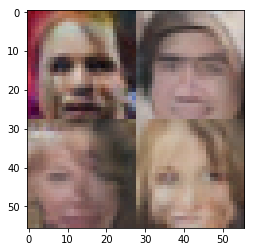

Epoch 9/30... Discriminator Loss: 1.0353... Generator Loss: 0.6570
Epoch 9/30... Discriminator Loss: 1.2554... Generator Loss: 0.4991
Epoch 9/30... Discriminator Loss: 1.1256... Generator Loss: 0.9850
Epoch 9/30... Discriminator Loss: 1.0566... Generator Loss: 0.7108
Epoch 9/30... Discriminator Loss: 1.1394... Generator Loss: 1.3681
Epoch 9/30... Discriminator Loss: 1.0490... Generator Loss: 0.8814
Epoch 9/30... Discriminator Loss: 1.1136... Generator Loss: 0.8978
Epoch 9/30... Discriminator Loss: 1.2420... Generator Loss: 0.6448
Epoch 9/30... Discriminator Loss: 1.3877... Generator Loss: 0.4664
Epoch 9/30... Discriminator Loss: 0.9948... Generator Loss: 1.4325


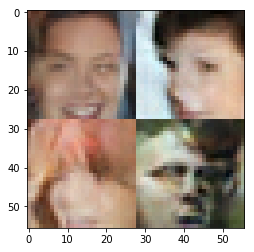

Epoch 9/30... Discriminator Loss: 0.3480... Generator Loss: 1.7732
Epoch 9/30... Discriminator Loss: 1.0771... Generator Loss: 0.7079
Epoch 9/30... Discriminator Loss: 1.0428... Generator Loss: 0.9314
epoch_i 9
Epoch 10/30... Discriminator Loss: 1.0745... Generator Loss: 1.0477
Epoch 10/30... Discriminator Loss: 1.1328... Generator Loss: 0.7257
Epoch 10/30... Discriminator Loss: 0.9361... Generator Loss: 0.9427
Epoch 10/30... Discriminator Loss: 1.0138... Generator Loss: 0.7472
Epoch 10/30... Discriminator Loss: 1.2723... Generator Loss: 0.5330
Epoch 10/30... Discriminator Loss: 1.3230... Generator Loss: 1.1012
Epoch 10/30... Discriminator Loss: 1.1371... Generator Loss: 0.8632


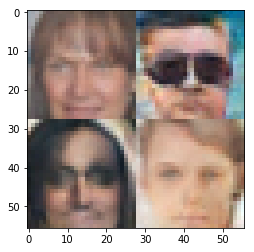

Epoch 10/30... Discriminator Loss: 1.0849... Generator Loss: 0.9384
Epoch 10/30... Discriminator Loss: 1.0012... Generator Loss: 0.9048
Epoch 10/30... Discriminator Loss: 1.2833... Generator Loss: 0.7150
Epoch 10/30... Discriminator Loss: 0.8606... Generator Loss: 0.7235
Epoch 10/30... Discriminator Loss: 0.4980... Generator Loss: 1.1986
Epoch 10/30... Discriminator Loss: 1.0350... Generator Loss: 0.6215
Epoch 10/30... Discriminator Loss: 1.6155... Generator Loss: 1.3050
Epoch 10/30... Discriminator Loss: 1.1204... Generator Loss: 0.6464
Epoch 10/30... Discriminator Loss: 0.1343... Generator Loss: 3.3721
Epoch 10/30... Discriminator Loss: 2.3556... Generator Loss: 0.1834


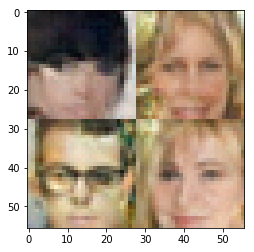

Epoch 10/30... Discriminator Loss: 2.1932... Generator Loss: 2.1556
Epoch 10/30... Discriminator Loss: 1.1220... Generator Loss: 0.8889
Epoch 10/30... Discriminator Loss: 1.3948... Generator Loss: 1.0650
Epoch 10/30... Discriminator Loss: 1.2711... Generator Loss: 0.8298
Epoch 10/30... Discriminator Loss: 1.2424... Generator Loss: 0.7124
Epoch 10/30... Discriminator Loss: 1.3667... Generator Loss: 0.5664
Epoch 10/30... Discriminator Loss: 1.2064... Generator Loss: 0.6834
Epoch 10/30... Discriminator Loss: 1.3661... Generator Loss: 0.6097
Epoch 10/30... Discriminator Loss: 1.0523... Generator Loss: 0.9201
Epoch 10/30... Discriminator Loss: 1.2870... Generator Loss: 0.7163


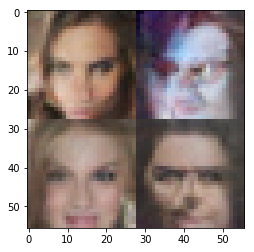

Epoch 10/30... Discriminator Loss: 1.2578... Generator Loss: 0.7824
Epoch 10/30... Discriminator Loss: 1.4358... Generator Loss: 0.6753
Epoch 10/30... Discriminator Loss: 1.3294... Generator Loss: 0.6308
Epoch 10/30... Discriminator Loss: 1.2408... Generator Loss: 0.8371
Epoch 10/30... Discriminator Loss: 1.0497... Generator Loss: 0.7457
Epoch 10/30... Discriminator Loss: 1.0793... Generator Loss: 0.8789
Epoch 10/30... Discriminator Loss: 1.5903... Generator Loss: 0.4586
Epoch 10/30... Discriminator Loss: 1.1150... Generator Loss: 0.8829
Epoch 10/30... Discriminator Loss: 1.0520... Generator Loss: 0.7137
Epoch 10/30... Discriminator Loss: 1.0885... Generator Loss: 0.7626


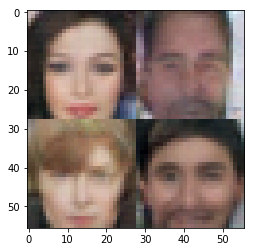

Epoch 10/30... Discriminator Loss: 1.4297... Generator Loss: 0.5021
Epoch 10/30... Discriminator Loss: 1.1691... Generator Loss: 0.6711
Epoch 10/30... Discriminator Loss: 1.2685... Generator Loss: 0.5708
Epoch 10/30... Discriminator Loss: 1.3222... Generator Loss: 0.6909
Epoch 10/30... Discriminator Loss: 1.3426... Generator Loss: 0.5175
Epoch 10/30... Discriminator Loss: 1.3914... Generator Loss: 0.4752
Epoch 10/30... Discriminator Loss: 1.1785... Generator Loss: 0.7549
Epoch 10/30... Discriminator Loss: 1.1409... Generator Loss: 1.0773
Epoch 10/30... Discriminator Loss: 1.1852... Generator Loss: 0.7649
Epoch 10/30... Discriminator Loss: 1.1730... Generator Loss: 0.9683


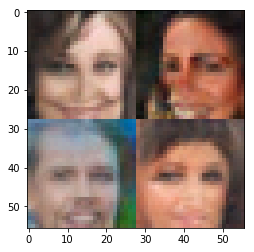

Epoch 10/30... Discriminator Loss: 1.2227... Generator Loss: 1.0819
Epoch 10/30... Discriminator Loss: 1.1288... Generator Loss: 1.0573
Epoch 10/30... Discriminator Loss: 1.0425... Generator Loss: 0.8125
Epoch 10/30... Discriminator Loss: 1.0209... Generator Loss: 0.9667
Epoch 10/30... Discriminator Loss: 1.2124... Generator Loss: 0.5887
Epoch 10/30... Discriminator Loss: 1.4243... Generator Loss: 0.4501
Epoch 10/30... Discriminator Loss: 1.1173... Generator Loss: 0.7604
Epoch 10/30... Discriminator Loss: 1.1700... Generator Loss: 0.6946
Epoch 10/30... Discriminator Loss: 1.1678... Generator Loss: 0.7738
Epoch 10/30... Discriminator Loss: 1.0191... Generator Loss: 1.0239


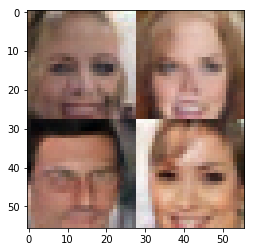

Epoch 10/30... Discriminator Loss: 1.0681... Generator Loss: 1.2489
Epoch 10/30... Discriminator Loss: 0.9362... Generator Loss: 0.9712
Epoch 10/30... Discriminator Loss: 1.2391... Generator Loss: 0.4958
Epoch 10/30... Discriminator Loss: 1.2595... Generator Loss: 0.6202
Epoch 10/30... Discriminator Loss: 1.3608... Generator Loss: 0.4953
Epoch 10/30... Discriminator Loss: 0.9957... Generator Loss: 0.9803
Epoch 10/30... Discriminator Loss: 1.2850... Generator Loss: 0.4932
Epoch 10/30... Discriminator Loss: 1.0323... Generator Loss: 0.8661
Epoch 10/30... Discriminator Loss: 1.5113... Generator Loss: 0.6396
Epoch 10/30... Discriminator Loss: 1.1304... Generator Loss: 0.6744


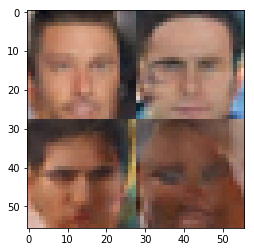

Epoch 10/30... Discriminator Loss: 1.1136... Generator Loss: 0.7905
Epoch 10/30... Discriminator Loss: 1.1873... Generator Loss: 0.7269
Epoch 10/30... Discriminator Loss: 1.1716... Generator Loss: 0.8431
Epoch 10/30... Discriminator Loss: 1.0817... Generator Loss: 0.8017
Epoch 10/30... Discriminator Loss: 1.0420... Generator Loss: 0.9188
Epoch 10/30... Discriminator Loss: 1.0551... Generator Loss: 0.9722
Epoch 10/30... Discriminator Loss: 1.2449... Generator Loss: 0.7064
Epoch 10/30... Discriminator Loss: 1.2311... Generator Loss: 1.1825
Epoch 10/30... Discriminator Loss: 1.4204... Generator Loss: 0.5237
Epoch 10/30... Discriminator Loss: 1.1853... Generator Loss: 0.6314


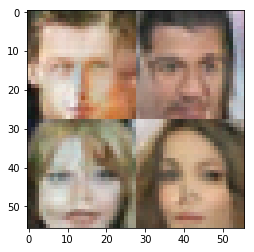

Epoch 10/30... Discriminator Loss: 0.9846... Generator Loss: 0.9286
Epoch 10/30... Discriminator Loss: 1.1728... Generator Loss: 0.7052
Epoch 10/30... Discriminator Loss: 1.6033... Generator Loss: 1.4760
Epoch 10/30... Discriminator Loss: 1.2866... Generator Loss: 1.0008
Epoch 10/30... Discriminator Loss: 1.2582... Generator Loss: 0.5476
Epoch 10/30... Discriminator Loss: 1.2929... Generator Loss: 0.6132
Epoch 10/30... Discriminator Loss: 1.1187... Generator Loss: 0.6971
Epoch 10/30... Discriminator Loss: 1.1463... Generator Loss: 0.9195
Epoch 10/30... Discriminator Loss: 1.2063... Generator Loss: 0.6496
Epoch 10/30... Discriminator Loss: 1.0566... Generator Loss: 0.9149


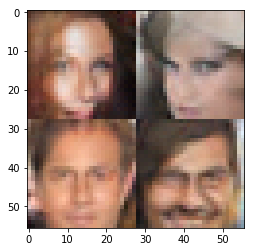

Epoch 10/30... Discriminator Loss: 1.0947... Generator Loss: 1.0502
Epoch 10/30... Discriminator Loss: 1.2376... Generator Loss: 0.6996
Epoch 10/30... Discriminator Loss: 1.2437... Generator Loss: 1.0790
Epoch 10/30... Discriminator Loss: 0.9827... Generator Loss: 1.1197
Epoch 10/30... Discriminator Loss: 1.4730... Generator Loss: 0.6355
Epoch 10/30... Discriminator Loss: 1.0324... Generator Loss: 1.4073
Epoch 10/30... Discriminator Loss: 1.4940... Generator Loss: 1.9533
Epoch 10/30... Discriminator Loss: 1.1303... Generator Loss: 0.5507
Epoch 10/30... Discriminator Loss: 1.8438... Generator Loss: 0.2164
Epoch 10/30... Discriminator Loss: 1.0959... Generator Loss: 1.1238


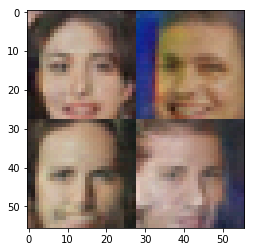

Epoch 10/30... Discriminator Loss: 1.2830... Generator Loss: 0.7464
Epoch 10/30... Discriminator Loss: 0.5803... Generator Loss: 1.8936
Epoch 10/30... Discriminator Loss: 0.9450... Generator Loss: 1.2676
Epoch 10/30... Discriminator Loss: 1.1556... Generator Loss: 0.6045
Epoch 10/30... Discriminator Loss: 0.9770... Generator Loss: 0.7044
Epoch 10/30... Discriminator Loss: 0.6104... Generator Loss: 1.0737
Epoch 10/30... Discriminator Loss: 1.5445... Generator Loss: 0.4582
Epoch 10/30... Discriminator Loss: 1.3260... Generator Loss: 0.5093
Epoch 10/30... Discriminator Loss: 2.1029... Generator Loss: 0.1887
Epoch 10/30... Discriminator Loss: 1.7019... Generator Loss: 0.2865


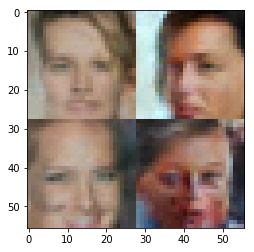

Epoch 10/30... Discriminator Loss: 1.4015... Generator Loss: 0.5747
Epoch 10/30... Discriminator Loss: 1.0604... Generator Loss: 1.0022
Epoch 10/30... Discriminator Loss: 0.9054... Generator Loss: 0.9041


KeyboardInterrupt: 

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 30

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.